## Import Libs

In [1]:
# Processamento e manipulação dos dados
import numpy as np # Importa a biblioteca numpy para suporte a arrays e funções matemáticas de alto nível
import openpyxl # Importa a biblioteca openpyxl para leitura e escrita de arquivos Excel (.xlsx)
import pandas as pd # Importa a biblioteca pandas para manipulação e análise de dados estruturados
import re # Importa o módulo re para operações com expressões regulares (strings)
import unicodedata # Importa unicodedata para manipulação e normalização de caracteres Unicode

# Visualização dos dados
import matplotlib.pyplot as plt # Importa o módulo pyplot da matplotlib para criação de gráficos estáticos
import seaborn as sns # Importa a biblioteca seaborn para visualização de dados estatísticos baseada em matplotlib
from matplotlib.colors import LinearSegmentedColormap # Importa classe para criação de mapas de cores personalizados no matplotlib

# Aplicações de pré-processamentos e pipelines
from sklearn.compose import ColumnTransformer # Importa o ColumnTransformer para aplicar transformações específicas em colunas
from sklearn.impute import KNNImputer # Importa o KNNImputer para imputação de valores ausentes baseada em vizinhos próximos
from sklearn.model_selection import train_test_split, cross_val_score # Importa funções para divisão de dados e validação cruzada
from sklearn.pipeline import Pipeline # Importa a classe Pipeline para sequenciar etapas de pré-processamento e modelagem
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Importa classes para escalonamento de atributos e codificação categórica

# Modelos e algorítimos
import xgboost as xgb # Importa a biblioteca XGBoost para modelos de Gradient Boosting de alta performance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Importa algoritmos de floresta aleatória e gradient boosting
from sklearn.linear_model import LogisticRegression # Importa o algoritmo de Regressão Logística para classificação

# Métricas de avaliação
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay) # Importa métricas de avaliação de modelos

# Sistema e estatísticas
import joblib # Importa a biblioteca joblib para persistência (salvamento/carregamento) de objetos Python e modelos
import os # Importa o módulo os para interação com o sistema operacional (pastas e variáveis)
import warnings # Importa o módulo warnings para controle de mensagens de alerta do sistema
from pathlib import Path # Importa a classe Path da pathlib para manipulação de caminhos de arquivos de forma agnóstica ao SO
from scipy import stats # Importa o módulo stats da scipy para funções e cálculos estatísticos

# Configuração do ambiente
warnings.filterwarnings('ignore') # Configura o filtro de avisos para ignorar e não exibir mensagens de alerta no console


## Funções

In [2]:
def padronizar_colunas(df, ano_referencia): # Define a função para processar e padronizar colunas e indicadores
    """Realiza a limpeza, padronização de colunas e cálculos de indicadores (INDE, Pedra, etc). Otimizado para performance usando vetorização do Pandas/Numpy.""" 
    df_result = df.copy() # Cria uma cópia do DataFrame original para garantir a integridade dos dados brutos
    ano_str = str(ano_referencia) # Converte o ano de referência para string para facilitar comparações e mapeamentos

    # 1. NORMALIZAÇÃO DE NOMES DE COLUNAS
    # Objetivo: Garantir que 'I.N.D.E 2022' ou 'inde' virem apenas 'INDE'.
    
    def normalize_str(s): # Define subfunção interna para normalizar strings de texto
        """Remove acentos, espaços e padroniza para minúsculo.""" # Docstring da subfunção de normalização
        return unicodedata.normalize('NFKD', str(s)).encode('ascii', 'ignore').decode('utf-8').lower().strip() # Aplica normalização Unicode para remover acentos e padronizar o texto

    # Mapeamentos fixos por ano (prioridade máxima)
    mapping = { # Cria dicionário de mapeamento específico para nomes de colunas variantes por ano
        '2022': {'INDE 22': 'INDE', 'Pedra 22': 'PEDRA'}, # Mapeia indicadores específicos do ciclo 2022
        '2023': {'INDE 2023': 'INDE', 'Pedra 2023': 'PEDRA'}, # Mapeia indicadores específicos do ciclo 2023
        '2024': {'INDE 2024': 'INDE', 'Pedra 2024': 'PEDRA'} # Mapeia indicadores específicos do ciclo 2024
    }.get(ano_str, {}) # Recupera o mapeamento correspondente ao ano fornecido ou retorna um dicionário vazio

    # Mapeamento de termos exatos
    exact_map = { # Define dicionário para conversão de siglas e termos fixos em nomes padronizados
        'iaa': 'IAA', 'ieg': 'IEG', 'ips': 'IPS', 'ipp': 'IPP', 'ida': 'IDA', 
        'ipv': 'IPV', 'ian': 'IAN', 'ra': 'RA', 'fase': 'FASE', 'cg': 'CG', 
        'cf': 'CF', 'ct': 'CT', 'genero': 'GENERO', 'gênero': 'GENERO'
    }

    new_cols = {} # Inicializa dicionário para armazenar as novas nomenclaturas de colunas
    for col in df_result.columns: # Inicia loop para percorrer todas as colunas existentes no DataFrame
        if col in mapping: # Verifica se a coluna atual possui um mapeamento prioritário definido para o ano
            new_cols[col] = mapping[col] # Atribui o novo nome baseado no mapeamento de ano
            continue # Pula para a próxima iteração do loop
        
        c_norm = normalize_str(col) # Normaliza o nome da coluna atual usando a subfunção normalize_str
        # Regras de busca por palavra-chave ou termo exato
        if c_norm in exact_map: new_cols[col] = exact_map[c_norm] # Renomeia se houver correspondência exata no mapa de termos
        elif 'idade' in c_norm: new_cols[col] = 'IDADE' # Identifica colunas de idade por busca parcial de termo
        elif any(x in c_norm for x in ['iaa', 'ipv', 'ieg', 'ips', 'ipp', 'ian']): new_cols[col] = c_norm[:3].upper() # Padroniza siglas de indicadores acadêmicos
        elif 'defas' in c_norm: new_cols[col] = 'DEFASAGEM' # Identifica colunas relacionadas à defasagem escolar
        elif 'fase ideal' in c_norm or 'nivel ideal' in c_norm: new_cols[col] = 'FASE_IDEAL' # Unifica variações de fase ou nível ideal
        elif 'atingiu pv' in c_norm or 'ponto_virada' in c_norm: new_cols[col] = 'PONTO_VIRADA' # Padroniza identificadores do ponto de virada
        elif 'ano ingresso' in c_norm or 'ano_ingresso' in c_norm: new_cols[col] = 'ANO_INGRESSO' # Unifica colunas de ano de ingresso no projeto
        elif 'nasc' in c_norm: new_cols[col] = 'ANO_NASCIMENTO' # Identifica colunas de ano de nascimento ou data de nascimento

    # Renomeia e remove colunas duplicadas que surgiram na padronização
    df_result = df_result.rename(columns=new_cols).loc[:, lambda x: ~x.columns.duplicated()] # Aplica renomeação e filtra o DataFrame para remover duplicidades de nomes de colunas
    df_result['ANO'] = ano_str # Adiciona a coluna de controle temporal com o ano de referência

    # 2. LIMPEZA DE DADOS E TIPAGEM
    
    # Padroniza nomes de gênero
    if 'GENERO' in df_result.columns: # Verifica se a coluna de gênero está presente no DataFrame
        df_result['GENERO'] = df_result['GENERO'].astype(str).str.strip().replace({ # Limpa espaços e unifica termos de gênero Masculino/Feminino
            'Menino': 'Masculino', 'menino': 'Masculino',
            'Menina': 'Feminino', 'menina': 'Feminino'
        })

    # Converte colunas críticas para número (transforma erros em NaN)
    cols_numeric = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP', 'IDADE', 'ANO_NASCIMENTO'] # Lista colunas que devem ser estritamente numéricas
    for col in cols_numeric: # Inicia loop para conversão de tipo de dado nas colunas selecionadas
        if col in df_result.columns: # Verifica a existência da coluna numérica no DataFrame atual
            df_result[col] = pd.to_numeric(df_result[col], errors='coerce') # Aplica conversão para float/int, tratando erros como nulos

    # 3. TRATAMENTO DE FASES (REGEX)
    # Extrai apenas os números de strings como "2ª Fase" ou "Nível 3"
    for col_fase in ['FASE', 'FASE_IDEAL']: # Inicia loop para processar colunas de fase e fase ideal
        if col_fase in df_result.columns: # Verifica se a coluna de fase está disponível para limpeza
            s = df_result[col_fase].astype(str).str.lower() # Converte valores para string em minúsculo para facilitar extração
            if col_fase == 'FASE': # Aplica lógica específica para a coluna principal de FASE
                # 'alfa' vira 0, outros termos extraem o primeiro número encontrado
                df_result[col_fase] = np.where(s.str.contains('alfa'), 0, s.str.extract(r'(\d+)')[0]) # Converte fase 'alfa' em zero ou extrai dígitos numéricos via regex
            else: # Aplica lógica para colunas secundárias de fase
                df_result[col_fase] = s.str.extract(r'(\d+)')[0] # Extrai apenas o componente numérico da string
            df_result[col_fase] = pd.to_numeric(df_result[col_fase], errors='coerce') # Finaliza convertendo os números extraídos para o tipo numérico

    # 4. CÁLCULO DE COLUNAS DERIVADAS
    # Preenche o que está faltando com base em outras colunas
    if 'DEFASAGEM' not in df_result.columns and {'FASE', 'FASE_IDEAL'}.issubset(df_result.columns): # Verifica condições para cálculo automático de defasagem
        df_result['DEFASAGEM'] = df_result['FASE'] - df_result['FASE_IDEAL'] # Calcula a defasagem pela diferença entre fase atual e ideal

    if 'IDADE' not in df_result.columns and 'ANO_NASCIMENTO' in df_result.columns: # Verifica condições para cálculo automático de idade
        df_result['IDADE'] = int(ano_referencia) - df_result['ANO_NASCIMENTO'] # Estima a idade baseada no ano de referência e nascimento

    if 'IDA' not in df_result.columns and set(['NOTA_MAT', 'NOTA_PORT', 'NOTA_ING']).issubset(df_result.columns): # Verifica condições para cálculo de desempenho acadêmico
        df_result['IDA'] = df_result[['NOTA_MAT', 'NOTA_PORT', 'NOTA_ING']].mean(axis=1) # Calcula a média das notas de matérias básicas como o IDA

    if 'IAA' not in df_result.columns and {'CG', 'CF', 'CT'}.issubset(df_result.columns): # Verifica condições para cálculo de autoavaliação
        df_result['IAA'] = df_result[['CG', 'CF', 'CT']].mean(axis=1) # Calcula a média dos indicadores de autoavaliação

    if 'IAN' not in df_result.columns and 'DEFASAGEM' in df_result.columns: # Verifica se o IAN pode ser derivado da defasagem
        df_result['IAN'] = df_result['DEFASAGEM'] # Atribui o valor de defasagem diretamente ao IAN

    # 5. CÁLCULO DO INDE (MÉDIA PONDERADA VETORIZADA)
    # Diferencia pesos para fases <= 7 e fases > 7 de forma massiva
    if 'INDE' not in df_result.columns and 'FASE' in df_result.columns: # Verifica se o INDE precisa ser calculado e se há dados de FASE
        indics = ['IAN', 'IDA', 'IEG', 'IAA', 'IPS', 'IPP', 'IPV'] # Define a lista de indicadores que compõem o INDE
        # Vetores de pesos oficiais
        pesos_fase_baixa = np.array([0.1, 0.2, 0.2, 0.1, 0.1, 0.1, 0.2]) # Define pesos para alunos em fases iniciais (até fase 7)
        pesos_fase_alta = np.array([0.1, 0.2, 0.2, 0.1, 0.1, 0.0, 0.0]) # Define pesos para alunos em fases avançadas (acima da fase 7)

        # Prepara matrizes para cálculo (mais rápido que .apply)
        data_matrix = df_result[indics].fillna(0).values # Converte indicadores em matriz numpy tratando nulos como zero
        mask_not_na = df_result[indics].notna().values # Cria máscara booleana para identificar dados reais e ignorar nulos na média
        
        # Define qual linha usa qual peso baseado na FASE
        is_baixa = (df_result['FASE'] <= 7).values[:, None] # Gera vetor booleano para identificar linhas que seguem o peso de fase baixa
        pesos_matrix = np.where(is_baixa, pesos_fase_baixa, pesos_fase_alta) # Constrói matriz de pesos personalizada para cada linha do DataFrame
        
        # Cálculo da média ponderada ignorando NaNs
        soma_ponderada = (data_matrix * pesos_matrix * mask_not_na).sum(axis=1) # Calcula o numerador da média ponderada (valores * pesos)
        soma_pesos = (pesos_matrix * mask_not_na).sum(axis=1) # Calcula o denominador da média ponderada (soma dos pesos presentes)
        
        df_result['INDE'] = np.where(soma_pesos > 0, soma_ponderada / soma_pesos, np.nan) # Atribui o resultado final do INDE ou NaN caso não haja pesos válidos

    # 6. CLASSIFICAÇÃO DE PEDRA (BINS)
    # Usa faixas numéricas para definir a categoria da pedra
    bins = [2.405, 5.506, 6.868, 8.230, 9.294] # Define os limites numéricos para cada categoria de pedra conforme regras da Passos Mágicos
    labels = ['QUARTZO', 'AGATA', 'AMETISTA', 'TOPAZIO'] # Define os nomes das categorias correspondentes aos limites definidos
    
    # Cria a classificação baseada no INDE
    calc_pedra = pd.cut(df_result['INDE'], bins=bins, labels=labels, right=False, include_lowest=True) # Aplica a discretização do INDE para gerar as categorias de pedra

    if 'PEDRA' in df_result.columns: # Verifica se a coluna PEDRA já existia no arquivo original
        # Se já existe a coluna PEDRA, limpa o texto e preenche vazios com o cálculo
        df_result['PEDRA'] = df_result['PEDRA'].astype(str).apply(normalize_str).str.upper().replace({'INCLUIR': np.nan, 'NAN': np.nan}) # Limpa strings de pedra existentes
        df_result['PEDRA'] = df_result['PEDRA'].fillna(calc_pedra.astype(object)) # Preenche lacunas de classificação com o valor calculado via INDE
    else: # Caso a coluna não exista
        df_result['PEDRA'] = calc_pedra # Atribui o resultado completo do cálculo de bins à nova coluna PEDRA

    # 7. PONTO DE VIRADA
    # Marcador booleano simples
    if 'PONTO_VIRADA' not in df_result.columns and 'INDE' in df_result.columns: # Verifica se o marcador de ponto de virada pode ser gerado
        df_result['PONTO_VIRADA'] = df_result['INDE'] >= 7 # Aplica a regra de negócio onde INDE maior ou igual a 7 caracteriza o ponto de virada

    return df_result # Retorna o DataFrame final totalmente processado e padronizado

In [3]:
def selecionar_colunas(df, colunas): # Define a função que recebe um DataFrame e um objeto de colunas para filtragem
    """Seleciona colunas usando interseção de índices""" 
    # intersection mantém a ordem de 'colunas' e filtra apenas as que existem no df
    cols_existentes = colunas.intersection(df.columns) # Compara o conjunto de colunas desejadas com as colunas reais do DataFrame e retorna apenas as presentes
    return df[cols_existentes] # Retorna o DataFrame contendo apenas as colunas que foram validadas na interseção

In [4]:
def criar_base_unificada(lista_dfs): # Define a função que recebe uma lista de DataFrames para consolidá-los em um só
    """Unifica uma lista de DataFrames, padroniza a coluna PEDRA e converte indicadores para o formato numérico."""
    # 1. Unificar bases de forma eficiente
    df_unificado = pd.concat(lista_dfs, ignore_index=True) # Concatena todos os DataFrames da lista em um único objeto, resetando o índice original

    # 2. Padronizar valores de PEDRA 
    if 'PEDRA' in df_unificado.columns: # Verifica se a coluna 'PEDRA' existe no DataFrame recém-unificado
        df_unificado['PEDRA'] = df_unificado['PEDRA'].replace('Agata', 'Ágata') # Substitui a grafia sem acento pela forma correta 'Ágata' para manter a consistência

    # 3. Converter indicadores para numérico 
    colunas_numericas = ['INDE', 'IAA', 'IEG', 'IPS', 'IPP', 'IDA', 'IPV', 'IAN', 'DEFASAGEM', 'IDADE'] # Define a lista de colunas que devem ser obrigatoriamente numéricas
    cols_presentes = df_unificado.columns.intersection(colunas_numericas) # Identifica quais dessas colunas alvo realmente existem no DataFrame unificado

    if not cols_presentes.empty: # Verifica se a lista de colunas presentes não está vazia antes de proceder
        df_unificado[cols_presentes] = df_unificado[cols_presentes].apply(pd.to_numeric, errors='coerce') # Converte as colunas para o tipo numérico, forçando erros a virarem NaN

    # Exibição de resultados 
    print(f'\n✅ DataFrame Unificado Criado') # Exibe uma mensagem de confirmação no console após a conclusão do processo

    return df_unificado # Retorna o DataFrame final, unificado e com os tipos de dados corrigidos

In [5]:
def aplicar_knn_ipp(df, n_vizinhos=5): # Define a função para preencher lacunas na coluna IPP usando o algoritmo de vizinhos mais próximos
    """Preenche valores ausentes da coluna 'IPP' usando o algoritmo KNN com base em IDA, IEG e IPS.""" 
    df_temp = df.copy() # Cria uma cópia local do DataFrame para garantir que a operação não afete os dados originais fora da função
    
    # Selecionamos as colunas numéricas fundamentais para a "vizinhança"
    # O KNN precisa de dados numéricos para calcular a distância entre alunos
    colunas_referencia = ['IDA', 'IEG', 'IPS', 'IPP'] # Define a lista de colunas que servirão de base para o cálculo de distância e preenchimento
    
    # Inicializamos o imputador
    imputer = KNNImputer(n_neighbors=n_vizinhos) # Instancia o objeto KNNImputer configurando o número de vizinhos (k) desejado
    
    # Aplicamos a imputação apenas nas colunas selecionadas
    df_temp[colunas_referencia] = imputer.fit_transform(df_temp[colunas_referencia]) # Executa o cálculo das distâncias e substitui os NaNs pelos valores estimados
    
    return df_temp # Retorna o DataFrame com a coluna IPP devidamente preenchida

In [6]:
def classificar_indicador(valor, nome_indicador, manual=None): # Define a função centralizada para rotular indicadores com base em um catálogo de regras interno, aceitando opcionalmente uma marcação manual
    """Mapeia valores numéricos para categorias qualitativas utilizando um dicionário de regras pré-definido, priorizando valores manuais quando fornecidos.""" 
    if pd.notna(manual): return manual # Retorna a marcação manual imediatamente caso ela exista, priorizando o histórico da ONG sobre o cálculo de score
    if pd.isna(valor): return "N/A" # Retorna "N/A" imediatamente caso o valor de entrada seja nulo para evitar falhas de comparação
    
    # Dicionário central contendo todas as regras de negócio do projeto Passos Mágicos
    mapa_regras = { # Inicia a estrutura de catálogo que agrupa os critérios de todos os indicadores
        'IAN': {10.0: 'Adequado', 5.0: 'Mod. Defasado', 0.0: 'Sev. Defasado'}, # Regras de adequação escolar
        'IEG': {8.5: 'Alto', 6.0: 'Médio', 0.0: 'Baixo'}, # Regras de engajamento do aluno
        'IDA': {7.5: 'Alto (>=7.5)', 5.0: 'Médio (5-7.5)', 0.0: 'Baixo (<5)'}, # Regras de desempenho acadêmico
        'IPS': {7.5: 'Adequado', 5.0: 'Em Alerta', 0.0: 'Crítico'}, # Regras de índice psicossocial
        'IPP': {8.0: 'Excelente', 7.0: 'Adequado', 0.0: 'Insuficiente'}, # Regras de potencial psicopedagógico
        'IAA': {8.5: 'Alta', 6.0: 'Média', 0.0: 'Baixa'}, # Regras de autoavaliação do aluno
        'IPV': {7.0: 'Sim', 0.0: 'Não'} # Regras para o indicador de Ponto de Virada
    }
    
    nome_indicador = nome_indicador.upper() # Normaliza o nome do indicador para maiúsculas para garantir a compatibilidade com as chaves do dicionário
    regras = mapa_regras.get(nome_indicador) # Recupera o conjunto específico de limites para o indicador solicitado
    
    if not regras: return "Indicador Inválido" # Retorna erro caso o nome do indicador passado não exista no mapa de regras
        
    for limite, rotulo in regras.items(): # Percorre os limites definidos para o indicador, do maior para o menor
        if valor >= limite: return rotulo # Retorna o primeiro rótulo que satisfaça a condição de valor mínimo
        
    return "N/A" # Retorna padrão caso o valor não atinja nenhuma das faixas estipuladas

In [7]:
def risco_defasagem(df_unificado): # Define a função lógica para identificar alunos em situação de vulnerabilidade acadêmica ou comportamental
    """Mapeia o nível de risco do aluno com base na defasagem escolar e indicadores de engajamento e desempenho."""
    
    # 1. AVALIAÇÃO ACADÊMICA: Identifica a defasagem real entre a fase atual e a idade ideal
    cond_academica = (df_unificado['DEFASAGEM'] < 0) # Marca como verdadeiro os casos onde o aluno está em uma fase inferior à esperada para sua idade para identificar atraso escolar
    
    # 2. SCORE DE COMPORTAMENTO: Acumula sinais de alerta baseados nos indicadores base da Passos Mágicos
    score_indicadores = ( # Inicia o cálculo somatório de fatores de risco individuais para compor o índice de vulnerabilidade multidimensional
        (df_unificado['IEG'] < 7.0).astype(int) +             # Avalia se o engajamento do aluno está abaixo do patamar mínimo de segurança estabelecido
        (df_unificado['IDA'] < 6.5).astype(int) +             # Verifica se o desempenho acadêmico apresenta sinais de insuficiência técnica para a fase atual
        (df_unificado['IPS'] < 6.0).astype(int) +             # Mede se o suporte psicossocial atingiu um nível crítico que exige intervenção imediata
        (df_unificado['PEDRA'] == 'QUARTZO').astype(int) +    # Considera a classificação Quartzo como um período de maior exposição e vulnerabilidade no ingresso
        (df_unificado['PONTO_VIRADA'] == 'Não').astype(int) + # Identifica a ausência do Ponto de Virada como um fator dificultador da evolução e permanência
        (df_unificado['IDADE'] > 15).astype(int)              # Adiciona peso à idade avançada por ser um fator estatístico diretamente correlacionado à evasão escolar
    ) # Finaliza a agregação dos seis componentes de risco para gerar um score de alerta comportamental
    
    # 3. DEFINIÇÃO DO LIMITE: Estabelece o critério técnico para rotular o aluno em situação de risco
    cond_comportamental = (score_indicadores >= 3) # Define que o acúmulo de três ou mais sinais negativos simultâneos caracteriza um estado de risco comportamental
    
    # 4. RETORNO DA VARIÁVEL: Consolida a análise clínica e estatística em um indicador binário
    return (cond_academica | cond_comportamental).astype(int) # Retorna o valor 1 se o aluno apresentar defasagem real ou múltiplos sinais de alerta, e 0 para situação regular

In [8]:
def treinar_e_avaliar_modelos(X_train, X_test, y_train, y_test, preprocessor): # Define a função de automação para treinamento simultâneo e comparação de múltiplos algoritmos de classificação
    """Executa o ciclo completo de treinamento, predição e extração de métricas de performance para diferentes arquiteturas de modelos."""
    
    # 1. DEFINIÇÃO DE ALGORITMOS: Estrutura o catálogo de modelos que serão testados no benchmark
    modelos = { # Inicia o dicionário de modelos para avaliar diferentes abordagens matemáticas (Linear, Bagging e Boosting)
        "Logistic Regression": LogisticRegression(random_state=123, max_iter=1000), # Instancia o modelo linear de base para calibração de complexidade inicial
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=123), # Configura a floresta aleatória para capturar relações não lineares via amostragem paralela
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=123) # Define o classificador de reforço de gradiente para otimização sequencial de erros
    } # Finaliza a seleção de candidatos para o processo de aprendizado supervisionado
    
    resultados_lista = [] # Inicializa a lista temporária para armazenamento dos indicadores de performance de cada execução
    modelos_treinados = {} # Cria o repositório de pipelines para persistência dos modelos ajustados após o treinamento

    # 2. CICLO DE PROCESSAMENTO: Itera sobre o catálogo para treinar e validar cada classificador
    for nome, modelo in modelos.items(): # Inicia a execução sequencial do fluxo de trabalho para cada algoritmo definido
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', modelo)]) # Constrói o pipeline integrando o pré-processamento de variáveis ao estimador final
        pipe.fit(X_train, y_train) # Executa o ajuste dos parâmetros do modelo com base nos dados históricos de treinamento
        modelos_treinados[nome] = pipe # Armazena o pipeline completo para futuras inferências ou deploy do projeto
        
        y_pred = pipe.predict(X_test) # Realiza as predições de classe no conjunto de teste para validação de performance
        y_proba = pipe.predict_proba(X_test)[:, 1] # Extrai as probabilidades de pertinência para o cálculo da curva ROC e métricas de separabilidade
        
        acc_train = accuracy_score(y_train, pipe.predict(X_train)) # Calcula a acurácia no treino para monitoramento de aprendizado do algoritmo
        acc_test = accuracy_score(y_test, y_pred) # Calcula a acurácia no teste para medir a capacidade real de generalização
        
        # 3. EXTRAÇÃO DE MÉTRICAS: Consolida os resultados estatísticos em uma estrutura de dados organizada
        resultados_lista.append({ # Alimenta a lista de resultados com os índices de qualidade obtidos no teste
            "Modelo": nome, # Identifica o nome do algoritmo avaliado na iteração corrente
            "Acurácia": acc_test, # Registra a taxa global de acerto do modelo no conjunto de dados inéditos
            "Precisão": precision_score(y_test, y_pred), # Mede a confiabilidade das predições positivas realizadas pelo classificador
            "Recall": recall_score(y_test, y_pred), # Avalia a sensibilidade do modelo em capturar todos os casos reais do evento alvo
            "F1-score": f1_score(y_test, y_pred), # Calcula a média harmônica entre precisão e recall para um balanço de performance
            "AUC-ROC": roc_auc_score(y_test, y_proba), # Mensura a área sob a curva para determinar o poder de discriminação entre classes
            "Overfit (%)": f"{(acc_train - acc_test) * 100:.2f}%" # Quantifica a disparidade entre treino e teste para detectar excesso de ajuste
        }) # Finaliza o registro das métricas fundamentais para a tomada de decisão técnica
    
    # 4. RETORNO DE DADOS: Organiza os resultados por qualidade para facilitar a escolha do melhor estimador
    return pd.DataFrame(resultados_lista).sort_values(by="AUC-ROC", ascending=False), modelos_treinados # Retorna o quadro comparativo ordenado por AUC-ROC e o dicionário de pipelines treinados
    

In [68]:
def plot_importancia_modelos(pipe_model, nome_modelo): # Define a função para extração e visualização gráfica do ranking de atributos de um pipeline do Scikit-Learn
    """Gera um diagnóstico visual das variáveis preditoras de maior impacto estatístico, adaptando-se a modelos lineares ou baseados em árvores."""
    
    # 1. RECUPERAÇÃO DE METADADOS: Acessa o preprocessor para extrair os nomes reais das colunas após as transformações
    num_features = pipe_model.named_steps['preprocessor'].transformers_[0][2] # Recupera os rótulos originais das variáveis quantitativas do transformador numérico
    cat_features = pipe_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out() # Extrai os nomes gerados pelo OneHotEncoder para as variáveis qualitativas
    
    # 2. UNIFICAÇÃO DE ATRIBUTOS: Consolida todos os nomes em um único vetor para mapeamento dos resultados
    colunas_totais = np.concatenate([num_features, cat_features]) # Une os vetores de nomes para criar um índice completo de todas as características preditoras
    
    # 3. EXTRAÇÃO DE IMPORTÂNCIA: Aplica a lógica de recuperação conforme a natureza matemática do algoritmo
    if nome_modelo == 'Logistic Regression': # Verifica se o modelo avaliado pertence à classe de regressores lineares
        # Calculamos a magnitude absoluta |β| pois o impacto (força) independe da direção (proteção ou risco)
        importancias = np.abs(pipe_model.named_steps['classifier'].coef_[0]) # Extrai o valor absoluto dos coeficientes para medir a força bruta da influência de cada variável
    else: # Direciona o fluxo para modelos baseados em conjuntos de árvores (Random Forest ou Boosting)
        importancias = pipe_model.named_steps['classifier'].feature_importances_ # Acessa o atributo nativo de importância de Gini ou Ganho de Informação do classificador
    
    # 4. RANKING DE VARIÁVEIS: Organiza e filtra os dados para a construção do Top 10
    feature_imp = pd.DataFrame({'Variável': colunas_totais, 'Importância': importancias}) # Constrói o DataFrame de mapeamento vinculando nomes aos seus respectivos pesos estatísticos
    feature_imp = feature_imp.sort_values(by='Importância', ascending=False).head(10) # Ordena o ranking de forma decrescente e filtra os dez principais componentes para exibição
    
    # 5. CONSTRUÇÃO VISUAL: Gera o gráfico de barras horizontais utilizando a paleta de cores definida
    plt.figure(figsize=(10, 5)) # Define as dimensões da moldura de plotagem para garantir a legibilidade dos atributos e valores
    sns.barplot(x='Importância', y='Variável', data=feature_imp, 
                palette=sns.color_palette("Set2", n_colors=10)) # Renderiza as barras horizontais utilizando um gradiente descendente para destacar a relevância

    plt.title(f'Top 10 Variáveis - {nome_modelo}', fontsize=16, fontweight='bold', pad=20) # Configura o título informativo destacando o nome do modelo e a finalidade da análise
    plt.xlabel('Nível de Importância') # Define a legenda do eixo horizontal representando a escala de impacto estatístico
    plt.ylabel('Atributos') # Define a legenda do eixo vertical listando os atributos preditores mapeados no ranking
    plt.grid(axis='x', linestyle='--', alpha=0.3) # Adiciona linhas de grade verticais suaves para facilitar a leitura e comparação dos valores de peso
    plt.tight_layout() # Ajusta automaticamente o espaçamento das margens para evitar sobreposições de rótulos e elementos do título
    plt.show() # Renderiza a figura consolidada para inspeção técnica das variáveis dominantes no processo de predição
    

In [70]:
def plot_matriz_confusao(pipe_model, X_test, y_test, nome_modelo): # Define a função para visualização da matriz de confusão para avaliar o equilíbrio entre erros e acertos do modelo selecionado
    """Gera uma representação visual da matriz de contingência comparando os valores reais com as predições binárias do classificador."""
    
    # 1. PREDIÇÃO: Executa a inferência nos dados de teste para obtenção dos rótulos preditos
    y_pred = pipe_model.predict(X_test) # Aplica o pipeline treinado sobre o conjunto de teste para gerar as classificações de risco do modelo

    # 2. CÁLCULO DA MATRIZ: Gera a tabela de contingência entre as classes reais e as preditas
    cm = confusion_matrix(y_test, y_pred) # Computa a frequência de acertos (diagonal principal) e erros cruzados para todas as combinações de classes
    
    # 3. CONFIGURAÇÃO DA FIGURA: Inicializa a moldura para a plotagem do gráfico de calor
    fig, ax = plt.subplots(figsize=(6, 5)) # Define as dimensões da área de plotagem para garantir a clareza visual dos quatro quadrantes da matriz
    
    # 4. OBJETO DE EXIBIÇÃO: Instancia o formatador da matriz com os rótulos de classe personalizados
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem Risco', 'Com Risco']) # Cria o objeto de visualização mapeando os índices numéricos para as categorias de risco acadêmico
    
    # 5. RENDERIZAÇÃO: Desenha o gráfico de calor com as configurações de estilo e cores
    disp.plot(cmap='GnBu', values_format='d', ax=ax, colorbar=False) # Plota a matriz no eixo definido utilizando a paleta de azuis e exibindo os valores absolutos em cada célula
    
    # 6. FINALIZAÇÃO VISUAL: Aplica os títulos e ajustes estéticos para apresentação do relatório
    plt.title(f'Matriz de Confusão: {nome_modelo}', pad=20) # Define o título informativo para identificação clara do algoritmo avaliado no diagnóstico
    plt.grid(False) # Desativa a grade de fundo para manter a estética limpa e focar exclusivamente nos valores da matriz
    plt.show() # Renderiza a figura consolidada para inspeção técnica da performance do modelo

## Importa base

In [11]:
# Mapeia link do csv no git
url = "https://raw.githubusercontent.com/geoferreira1/fiap_tech_challenge_fase_5/refs/heads/main/data_raw/base_passos_magicos.xlsx" # Define a URL direta do repositório GitHub onde o arquivo Excel está hospedado
caminho_local = Path.cwd().parent / 'data' / 'raw' / 'base_passos_magicos.xlsx' # Define um caminho local alternativo utilizando a biblioteca pathlib para navegação entre pastas

# Lê arquivo do git
print(f"Leitura da base de dados no GitHub.") # Exibe no console uma mensagem informativa sobre o início da leitura dos dados remotos
xlsx = pd.ExcelFile(url) # Utiliza o pandas para abrir o arquivo Excel e carregar seus metadados (como nomes de abas) sem ler os dados ainda
print(f'📁 Abas disponíveis: {xlsx.sheet_names}') # Imprime a lista com os nomes de todas as abas (planilhas) encontradas dentro do arquivo Excel

# Carregar cada aba em um DataFrame separado
df_2022 = pd.read_excel(xlsx, sheet_name='PEDE2022') # Carrega os dados da aba referente ao ano de 2022 para a variável df_2022
df_2023 = pd.read_excel(xlsx, sheet_name='PEDE2023') # Carrega os dados da aba referente ao ano de 2023 para a variável df_2023
df_2024 = pd.read_excel(xlsx, sheet_name='PEDE2024') # Carrega os dados da aba referente ao ano de 2024 para a variável df_2024

print(f'\n📊 Arquivos carregados:') # Exibe um cabeçalho no console para o resumo do carregamento dos arquivos
print(f'   PEDE 2022: {df_2022.shape[0]:,} alunos, {df_2022.shape[1]} variáveis') # Mostra a quantidade de linhas e colunas carregadas para o dataset de 2022
print(f'   PEDE 2023: {df_2023.shape[0]:,} alunos, {df_2023.shape[1]} variáveis') # Mostra a quantidade de linhas e colunas carregadas para o dataset de 2023
print(f'   PEDE 2024: {df_2024.shape[0]:,} alunos, {df_2024.shape[1]} variáveis') # Mostra a quantidade de linhas e colunas carregadas para o dataset de 2024

Leitura da base de dados no GitHub.
📁 Abas disponíveis: ['PEDE2022', 'PEDE2023', 'PEDE2024']

📊 Arquivos carregados:
   PEDE 2022: 860 alunos, 42 variáveis
   PEDE 2023: 1,014 alunos, 48 variáveis
   PEDE 2024: 1,156 alunos, 50 variáveis


In [12]:
# 1. Aplicação da padronização
df_2022_padronizado = padronizar_colunas(df_2022, '2022') # Aplica a função de limpeza e cálculos estatísticos aos dados brutos de 2022
df_2023_padronizado = padronizar_colunas(df_2023, '2023') # Aplica a função de limpeza e cálculos estatísticos aos dados brutos de 2023
df_2024_padronizado = padronizar_colunas(df_2024, '2024') # Aplica a função de limpeza e cálculos estatísticos aos dados brutos de 2024

# 2. Seleciona colunas principais
colunas_principais = pd.Index(['RA', 'ANO', 'FASE', 'PEDRA', 'INDE', 'IAA', 'IEG', 'IPS', 'IPP', 
                              'IDA', 'IPV', 'IAN', 'DEFASAGEM', 'GENERO', 'IDADE', 
                              'ANO_INGRESSO', 'PONTO_VIRADA']) # Cria um índice do pandas contendo a lista oficial de variáveis necessárias para o projeto

# 3. Aplicar as funções
dfs_padronizado = {'2022': df_2022_padronizado, '2023': df_2023_padronizado, '2024': df_2024_padronizado} # Organiza os DataFrames padronizados em um dicionário para facilitar iterações
dfs_colunas = {ano: selecionar_colunas(df, colunas_principais) 
           for ano, df in dfs_padronizado.items()} # Percorre o dicionário e aplica a função de seleção para manter apenas as colunas principais em cada ano

# 4. Atribuindo de volta às variáveis individuais para manter seu fluxo
df_2022_sel = dfs_colunas['2022'] # Extrai o DataFrame filtrado de 2022 do dicionário para uma variável individual
df_2023_sel = dfs_colunas['2023'] # Extrai o DataFrame filtrado de 2023 do dicionário para uma variável individual
df_2024_sel = dfs_colunas['2024'] # Extrai o DataFrame filtrado de 2024 do dicionário para uma variável individual

print('✅ Colunas selecionadas com sucesso!') # Exibe uma mensagem de confirmação no console após a conclusão do processo de seleção
for ano, df in dfs_colunas.items(): # Inicia um loop para percorrer os nomes dos anos e seus respectivos DataFrames processados
    print(f'{ano}: {df.shape[1]} colunas selecionadas.') # Imprime no console a contagem final de colunas para cada ano processado

✅ Colunas selecionadas com sucesso!
2022: 16 colunas selecionadas.
2023: 17 colunas selecionadas.
2024: 17 colunas selecionadas.


In [13]:
# 1. Unifica as bases padronizadas para uso e análise
lista_de_bases = [df_2022_sel, df_2023_sel, df_2024_sel] # Cria uma lista contendo os DataFrames selecionados de cada ano para facilitar a consolidação em lote
df_unificado = criar_base_unificada(lista_de_bases) # Chama a função de unificação para agrupar todas as bases anuais em um único DataFrame padronizado e tipado

# 2. Aplica o KNN para preencher o IPP de 2022 com base no perfil dos anos seguintes
df_unificado = aplicar_knn_ipp(df_unificado) # Aplica a técnica de K-Nearest Neighbors para imputar valores faltantes na coluna IPP baseando-se em indicadores correlatos

df_unificado.head() # Exibe as cinco primeiras linhas do DataFrame unificado para conferência visual imediata da estrutura e dos dados


✅ DataFrame Unificado Criado


,RA,ANO,FASE,PEDRA,INDE,IAA,IEG,IPS,IDA,IPV,IAN,DEFASAGEM,GENERO,IDADE,ANO_INGRESSO,PONTO_VIRADA,IPP
0,RA-1,2022,7,QUARTZO,5.783,8.3,4.1,5.6,4.0,7.278,5.0,-1,Feminino,19.0,2016,Não,7.402083
1,RA-2,2022,7,AMETISTA,7.055,8.8,5.2,6.3,6.8,6.778,10.0,0,Feminino,17.0,2017,Não,7.416667
2,RA-3,2022,7,AGATA,6.591,0.0,7.9,5.6,5.6,7.556,10.0,0,Feminino,17.0,2016,Não,7.400000
3,RA-4,2022,7,QUARTZO,5.951,8.8,4.5,5.6,5.0,5.278,10.0,0,Masculino,17.0,2017,Não,7.277083
4,RA-5,2022,7,AMETISTA,7.427,7.9,8.6,5.6,5.2,7.389,10.0,0,Feminino,17.0,2016,Não,7.531250


In [14]:
# 1. Define a estrutura de pastas
# Path.cwd() -> Pasta atual (ex: notebooks)
# .parent    -> Sobe um nível (Raiz do projeto)
# / 'dados_processados' -> Define a pasta de destino dentro do parent
diretorio_pai = Path.cwd().parent # Utiliza a biblioteca pathlib para identificar o diretório acima da pasta de execução atual
pasta_destino = diretorio_pai / 'fiap_tech_challenge_fase_5' / 'data_processed' # Constrói o caminho completo onde os dados tratados serão armazenados

# 2. Cria a pasta fisicamente se ela não existir
# parents=True: cria pastas intermediárias se necessário
# exist_ok=True: não dá erro se a pasta já existir
pasta_destino.mkdir(parents=True, exist_ok=True) # Executa a criação física do diretório no sistema operacional, garantindo que subpastas sejam criadas sem disparar erros se já existirem

# 3. Define o nome do arquivo e o caminho completo
nome_arquivo = 'df_unificado.csv' # Define uma string com o nome e a extensão desejada para o arquivo de saída
caminho_final = pasta_destino / nome_arquivo # Combina o caminho da pasta de destino com o nome do arquivo para formar o endereçamento completo no disco

# 4. Salva o DataFrame
# index=False: não salva a coluna de índices do pandas
# encoding='utf-8-sig': garante que acentos fiquem corretos no Excel e outros editores
df_unificado.to_csv(caminho_final, index=False, encoding='utf-8-sig') # Exporta o DataFrame para o formato CSV, removendo o índice numérico e aplicando codificação compatível com caracteres especiais

print("-" * 30) # Imprime uma linha separadora visual de 30 caracteres no console
print(f"✅ Sucesso!") # Exibe uma mensagem de confirmação de que a operação de salvamento foi concluída
print(f"📁 Pasta: 'fiap_tech_challenge_fase_5'/ 'data_processed'") # Informa ao usuário em qual estrutura de diretórios o arquivo foi guardado
print(f"📄 Arquivo: {nome_arquivo}") # Confirma o nome do arquivo que foi gerado no processo
print("-" * 30) # Imprime outra linha separadora visual para encerrar o log de saída

------------------------------
✅ Sucesso!
📁 Pasta: 'fiap_tech_challenge_fase_5'/ 'data_processed'
📄 Arquivo: df_unificado.csv
------------------------------


## Análise exploratória

In [15]:
# 1. Mostra as primeiras linhas, tipos de dados e memória utilizada
display(df_unificado.head()) # Renderiza visualmente as primeiras 5 linhas do DataFrame unificado para conferência rápida de valores
print(df_unificado.info()) # Imprime no console o resumo técnico do DataFrame, incluindo contagem de não-nulos, tipos de cada coluna (dtype) e o uso total de memória RAM

,RA,ANO,FASE,PEDRA,INDE,IAA,IEG,IPS,IDA,IPV,IAN,DEFASAGEM,GENERO,IDADE,ANO_INGRESSO,PONTO_VIRADA,IPP
0,RA-1,2022,7,QUARTZO,5.783,8.3,4.1,5.6,4.0,7.278,5.0,-1,Feminino,19.0,2016,Não,7.402083
1,RA-2,2022,7,AMETISTA,7.055,8.8,5.2,6.3,6.8,6.778,10.0,0,Feminino,17.0,2017,Não,7.416667
2,RA-3,2022,7,AGATA,6.591,0.0,7.9,5.6,5.6,7.556,10.0,0,Feminino,17.0,2016,Não,7.400000
3,RA-4,2022,7,QUARTZO,5.951,8.8,4.5,5.6,5.0,5.278,10.0,0,Masculino,17.0,2017,Não,7.277083
4,RA-5,2022,7,AMETISTA,7.427,7.9,8.6,5.6,5.2,7.389,10.0,0,Feminino,17.0,2016,Não,7.531250


<class 'pandas.DataFrame'>
RangeIndex: 3030 entries, 0 to 3029
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RA            3030 non-null   str    
 1   ANO           3030 non-null   str    
 2   FASE          3030 non-null   int64  
 3   PEDRA         2845 non-null   str    
 4   INDE          2845 non-null   float64
 5   IAA           2865 non-null   float64
 6   IEG           3030 non-null   float64
 7   IPS           3030 non-null   float64
 8   IDA           3030 non-null   float64
 9   IPV           2852 non-null   float64
 10  IAN           3030 non-null   float64
 11  DEFASAGEM     3030 non-null   int64  
 12  GENERO        3030 non-null   str    
 13  IDADE         2631 non-null   float64
 14  ANO_INGRESSO  3030 non-null   int64  
 15  PONTO_VIRADA  860 non-null    object 
 16  IPP           3030 non-null   float64
dtypes: float64(9), int64(3), object(1), str(4)
memory usage: 402.6+ KB
None


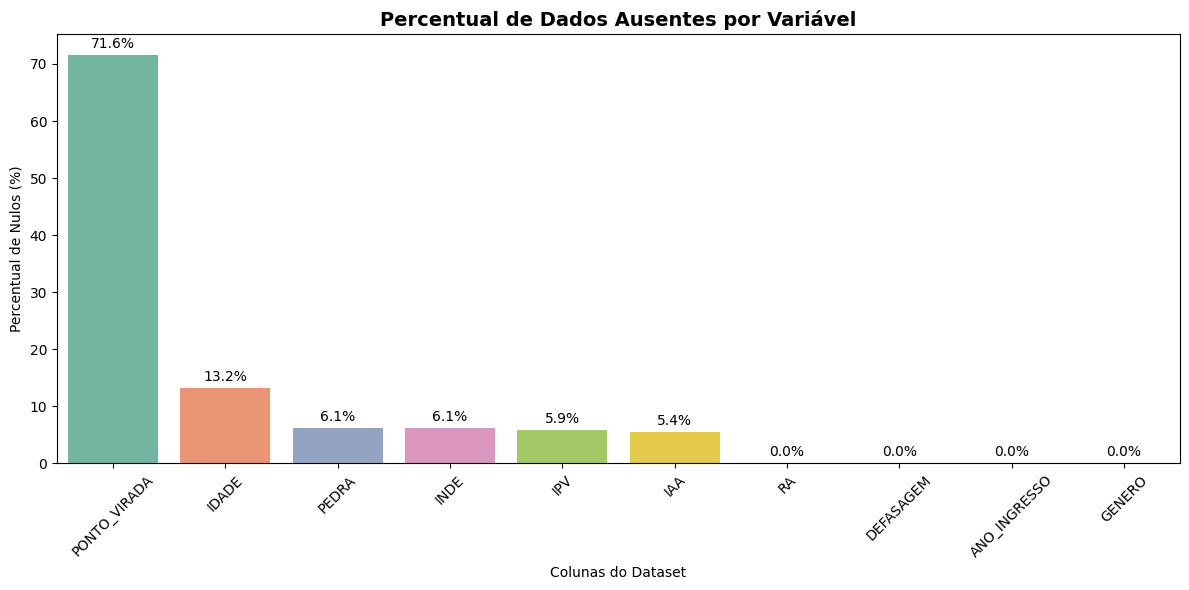

In [16]:
# 1. Cria uma nova figura com tamanho específico para o gráfico
plt.figure(figsize=(12, 6)) # Define as dimensões da área de plotagem para 12 polegadas de largura por 6 de altura

# 2. Calcula o percentual de valores nulos em cada coluna e ordena do maior para o menor
null_perc = (df_unificado.isnull().sum() / len(df_unificado) * 100).sort_values(ascending=False) # Calcula a soma de nulos por coluna, divide pelo total de linhas e ordena os resultados

# 3. Cria o gráfico de barras e armazena o objeto na variável 'ax' para permitir edições
ax = sns.barplot(x=null_perc.index[:10], y=null_perc.values[:10], palette='Set2') # Gera um gráfico de barras com as 10 colunas mais críticas usando uma paleta de cores pré-definida

# 4. Adiciona o rótulo de dados em TODAS as colunas do gráfico
for container in ax.containers: # Percorre todos os grupos de barras (objetos visuais) gerados pelo seaborn
    ax.bar_label(container, fmt='%.1f%%', padding=3) # Adiciona o valor percentual formatado acima de cada barra com um pequeno espaçamento

plt.title('Percentual de Dados Ausentes por Variável', fontsize=14, fontweight='bold') # Define o título principal do gráfico com fonte maior e em destaque negrito
plt.ylabel('Percentual de Nulos (%)') # Atribui o nome descritivo para o eixo Y (eixo vertical)
plt.xlabel('Colunas do Dataset') # Atribui o nome descritivo para o eixo X (eixo horizontal)
plt.xticks(rotation=45) # Aplica uma rotação de 45 graus nos textos do eixo X para evitar sobreposição de nomes longos
plt.tight_layout() # Executa o ajuste automático de margens para garantir que todos os elementos do gráfico caibam na imagem
plt.show() # Renderiza e exibe o gráfico finalizado na tela

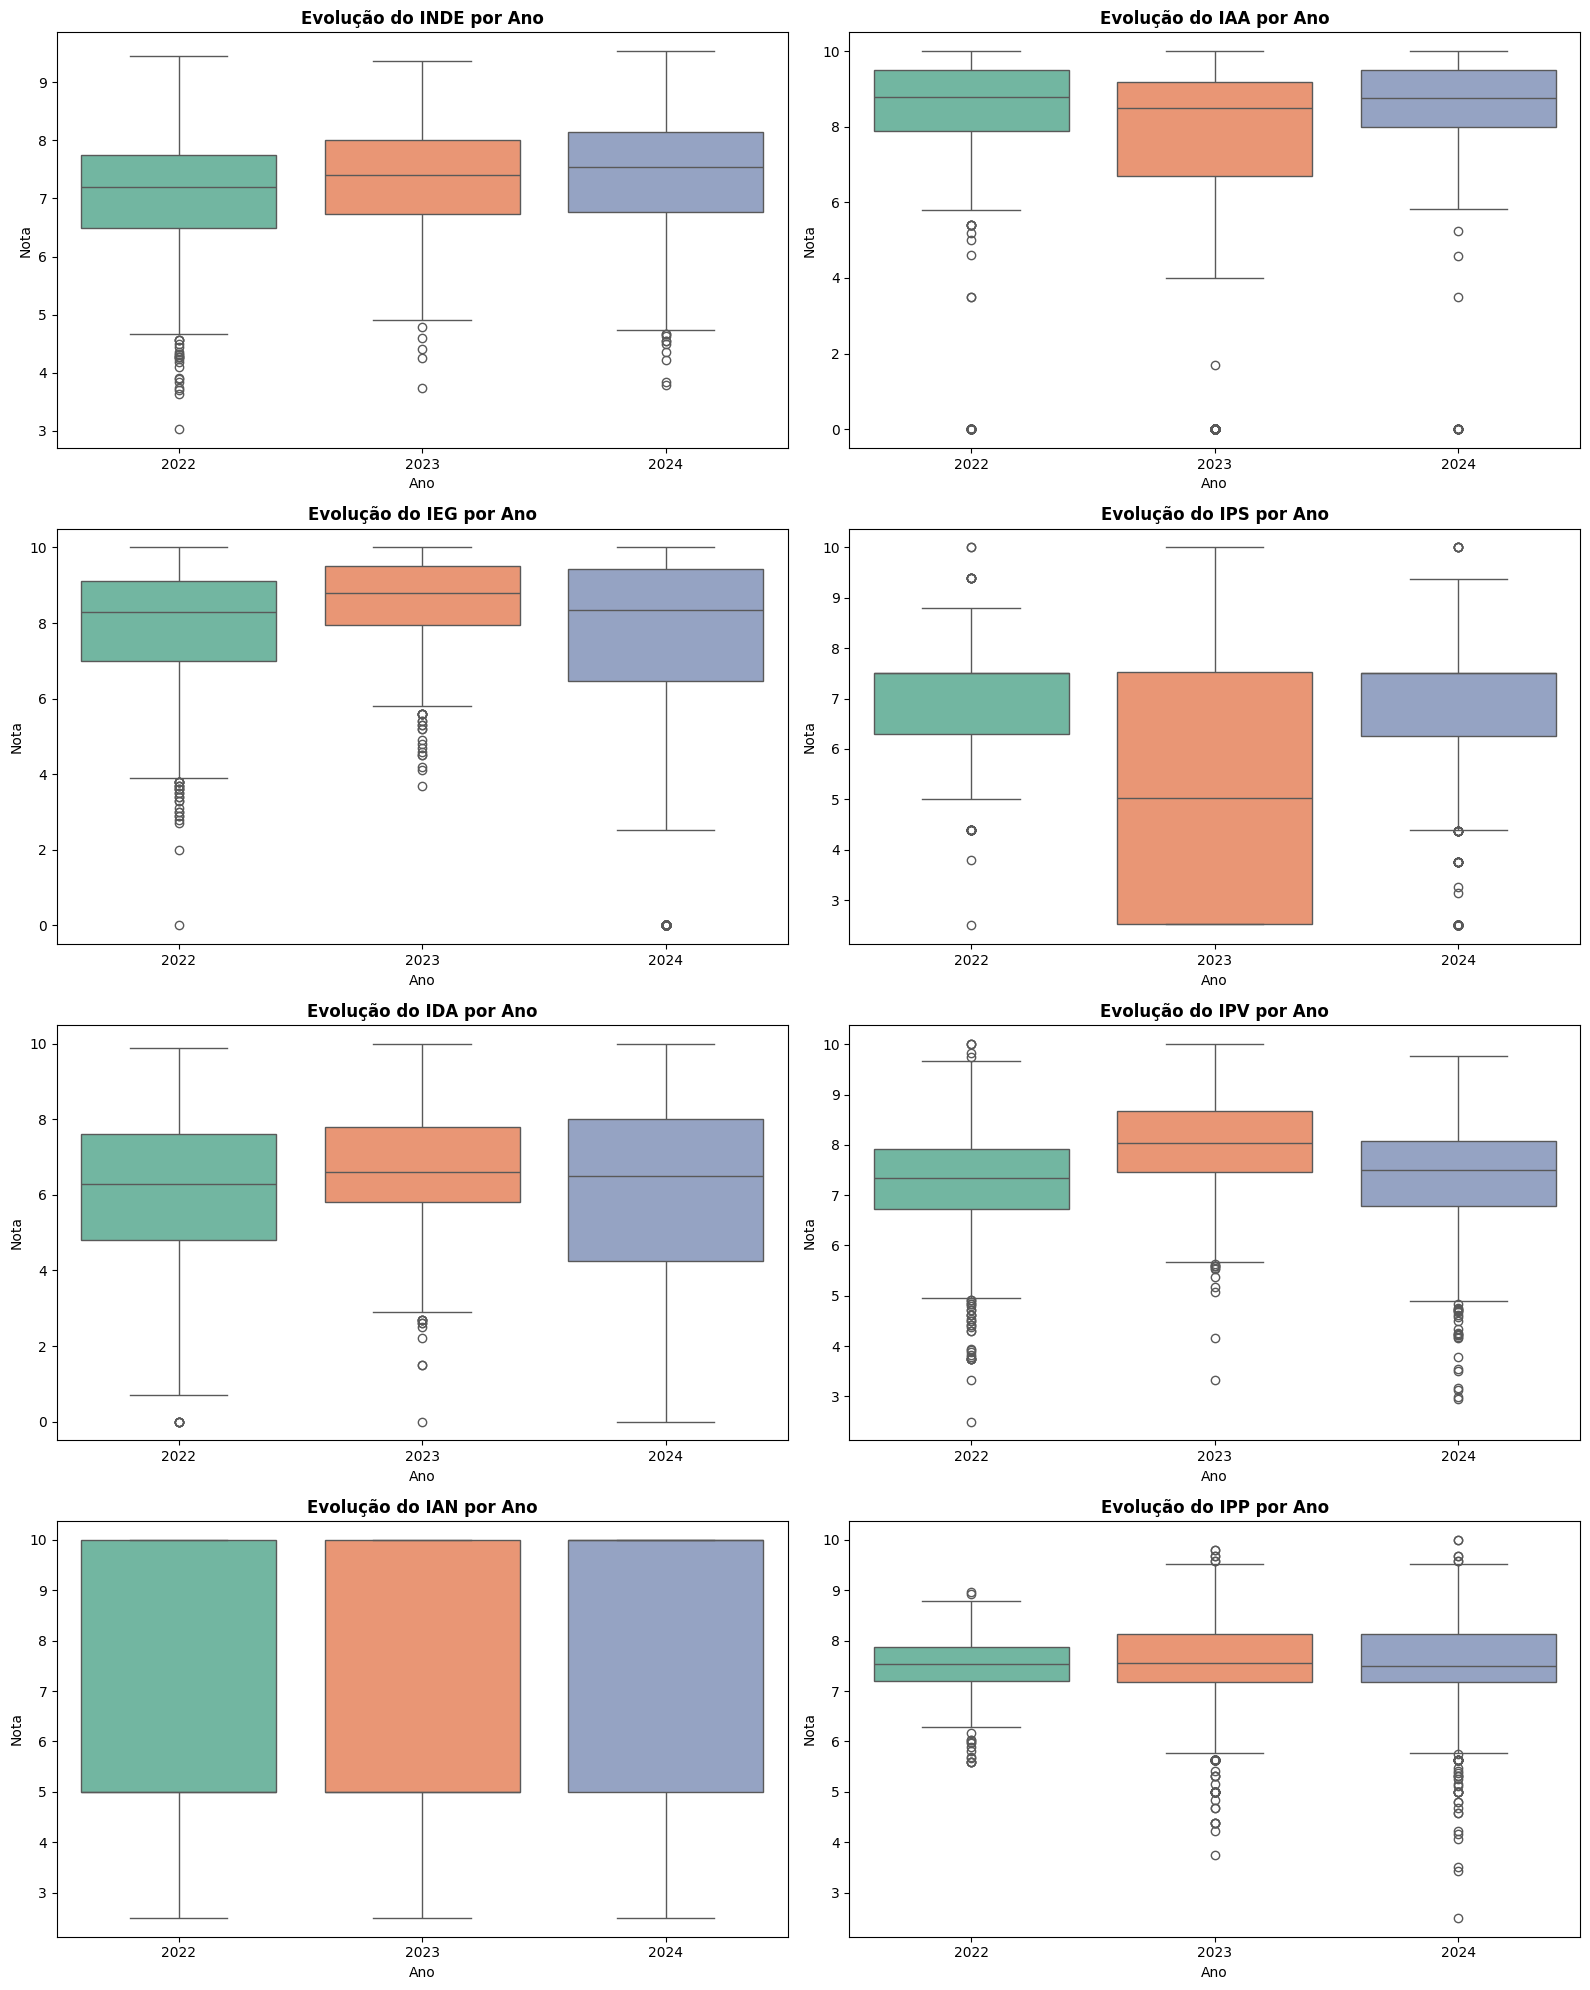

In [17]:
# 1. Lista de indicadores para a análise
indicadores = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP'] # Define a lista de siglas dos indicadores que serão analisados individualmente

# 2. Tratamento de dados: Garantir que todos os indicadores sejam numéricos
for col in indicadores: # Inicia um loop para percorrer cada nome de coluna na lista de indicadores
    df_unificado[col] = pd.to_numeric(df_unificado[col], errors='coerce') # Converte os valores da coluna para float/int, transformando erros em valores nulos (NaN)

# 3. Tratamento do ANO: Converter para string para evitar espaços vazios no gráfico
df_unificado['ANO'] = df_unificado['ANO'].astype(str) # Transforma a coluna ANO em texto para garantir que o Matplotlib trate os anos como categorias discretas

# 4. Configuração da grade de subplots (4 linhas x 2 colunas)
fig, axes = plt.subplots(4, 2, figsize=(16, 20)) # Cria uma moldura de gráfico dividida em 8 espaços (4x2) com dimensões de 16x20 polegadas
axes = axes.flatten() # Converte a matriz bidimensional de eixos em um vetor unidimensional para permitir a iteração por índice simples

# 5. Loop para criar um boxplot para cada indicador
for i, col in enumerate(indicadores): # Inicia um loop que percorre a lista de indicadores mantendo o rastreio do índice (i) e do nome (col)
    sns.boxplot(data=df_unificado, x='ANO', y=col, ax=axes[i], palette='Set2', order=['2022', '2023', '2024']) # Gera um gráfico de caixa para o indicador atual, segregado por ano e na ordem cronológica
    
    # Define o título de cada subgráfico
    axes[i].set_title(f'Evolução do {col} por Ano', fontsize=12, fontweight='bold') # Aplica um título descritivo e estilizado para o subplot específico da iteração atual
    # Nomeia os eixos
    axes[i].set_xlabel('Ano') # Define o rótulo do eixo horizontal como 'Ano' para o subplot atual
    axes[i].set_ylabel('Nota') # Define o rótulo do eixo vertical como 'Nota' para o subplot atual

# 6. Ajuste final de layout para evitar sobreposição de títulos
plt.tight_layout() # Recalcula automaticamente as margens entre os subplots para garantir que textos e eixos não se sobreponham
plt.show() # Renderiza a figura completa com todos os 8 gráficos na interface do notebook

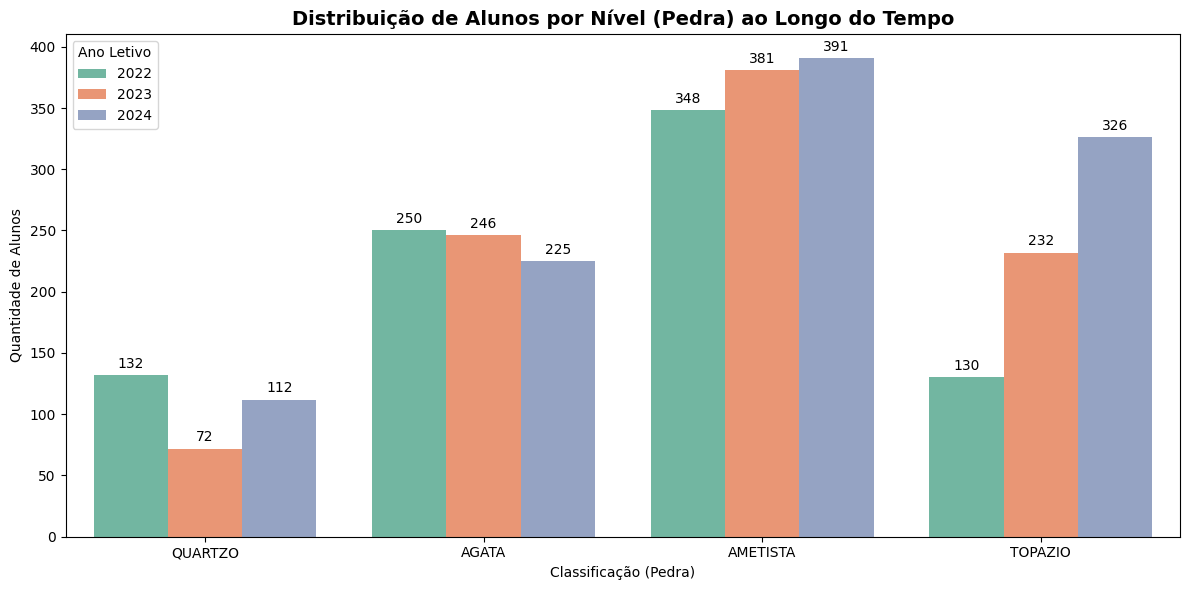

In [18]:
# 1. Define a ordem lógica das pedras do nível mais baixo ao mais alto
ordem = ['QUARTZO', 'AGATA', 'AMETISTA', 'TOPAZIO'] # Cria uma lista com a hierarquia das categorias para garantir a ordenação correta no gráfico

# 2. Filtra o dataframe para conter apenas as pedras que estão na nossa lista de interesse
df_filtro_pedras = df_unificado[df_unificado['PEDRA'].isin(ordem)] # Cria um subconjunto dos dados removendo categorias irrelevantes ou erros de preenchimento
plt.figure(figsize=(12, 6)) # Define as dimensões da nova área de plotagem para 12 polegadas de largura por 6 de altura

# 3. Cria o gráfico (countplot) e armazena em 'ax' para permitir a inclusão dos rótulos
ax = sns.countplot(data=df_filtro_pedras, x='PEDRA', hue='ANO', order=ordem, palette='Set2') # Gera um gráfico de barras que conta as ocorrências por categoria, segregado por ano

# 4. Adiciona o rótulo de dados (contagem) em TODAS as barras do gráfico
for container in ax.containers: # Percorre cada um dos conjuntos de barras associados aos diferentes anos (hue)
    ax.bar_label(container, fontsize=10, padding=3) # Adiciona o número total de alunos acima de cada barra específica para facilitar a leitura direta

plt.title('Distribuição de Alunos por Nível (Pedra) ao Longo do Tempo', fontsize=14, fontweight='bold') # Configura o título principal com destaque visual e aumento da fonte
plt.xlabel('Classificação (Pedra)') # Atribui o nome descritivo para o eixo das abscissas (horizontal)
plt.ylabel('Quantidade de Alunos') # Atribui o nome descritivo para o eixo das ordenadas (vertical)
plt.legend(title='Ano Letivo') # Inclui a legenda explicativa para as cores, rotulando-a como 'Ano Letivo'
plt.tight_layout() # Executa o ajuste fino de margens e espaçamentos para evitar sobreposições de elementos
plt.show() # Finaliza a renderização e apresenta o gráfico formatado na tela

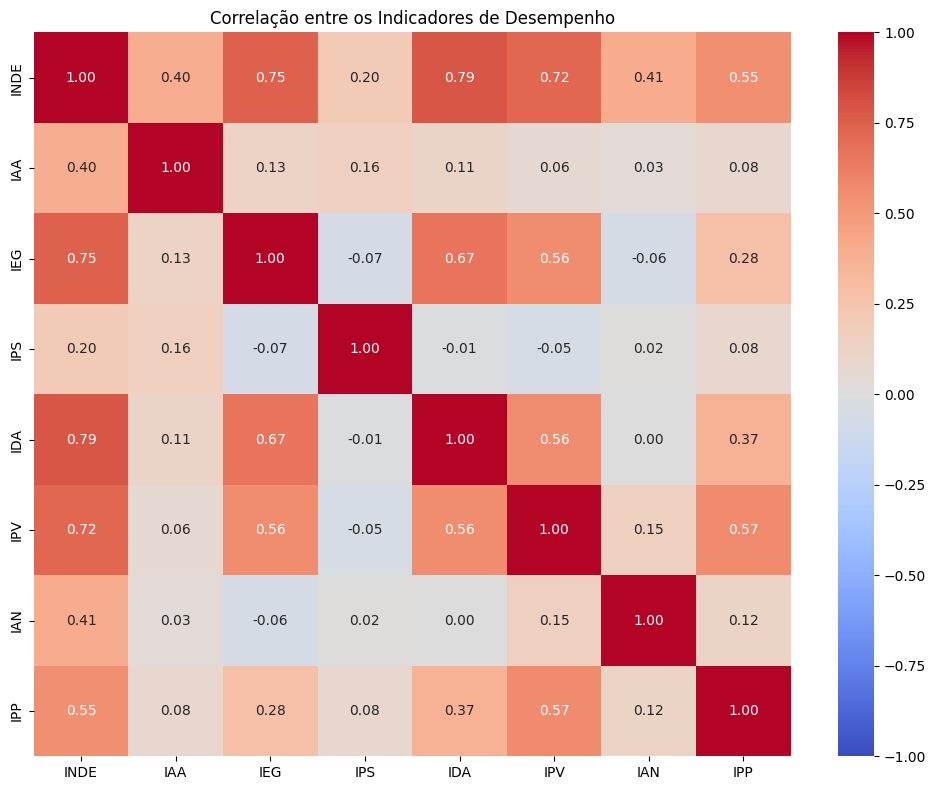

In [19]:
# 1. Lista as colunas numéricas que representam os indicadores educacionais
indicadores = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP'] # Define o conjunto de variáveis métricas que serão comparadas estatisticamente

# 2. Calcula a matriz de correlação de Pearson entre esses indicadores
matriz_corr = df_unificado[indicadores].corr() # Gera uma matriz quadrada contendo os coeficientes de correlação de Pearson para cada par de variáveis
plt.figure(figsize=(10, 8)) # Inicializa uma nova área de desenho com proporções de 10 por 8 polegadas para garantir legibilidade

# 3. Cria um mapa de calor (heatmap) com os valores de correlação escritos dentro das células (annot=True)
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1) # Plota a matriz colorida, exibindo os valores internos, com escala de cores de -1 a 1
plt.title('Correlação entre os Indicadores de Desempenho') # Adiciona o título descritivo na parte superior do gráfico para identificação do conteúdo
plt.tight_layout() # Aplica o ajuste automático dos elementos visuais para garantir que nenhum rótulo ou legenda seja cortado na visualização
plt.show() # Finaliza o processamento gráfico e renderiza a imagem final no console do notebook

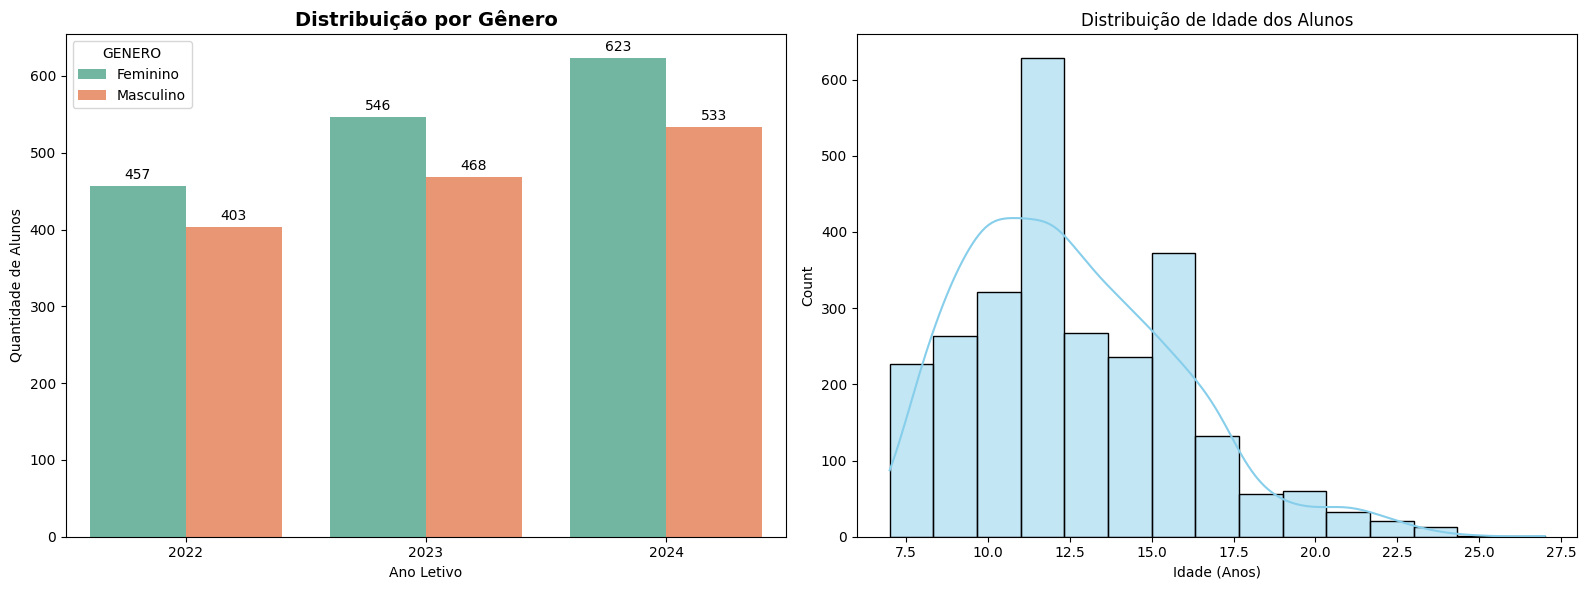

In [20]:
# 1. Cria uma figura dividida em 1 linha e 2 colunas para colocar dois gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6)) # Inicializa uma moldura com dois espaços laterais para comparação simultânea de dados distintos

# 2. Gráfico da esquerda: Contagem por gênero
ax1 = sns.countplot(data=df_unificado, x='ANO', hue='GENERO', ax=ax1, palette='Set2') # Gera o gráfico de barras comparando o volume de alunos por gênero em cada ano letivo
for container in ax1.containers: # Percorre as coleções de objetos visuais (barras) para cada categoria de gênero mapeada
    ax1.bar_label(container, fontsize=10, padding=3) # Insere a etiqueta numérica exata sobre cada barra para conferência precisa dos dados
ax1.set_title('Distribuição por Gênero', fontsize=14, fontweight='bold') # Aplica um título em destaque para a primeira visualização de dados
ax1.set_xlabel('Ano Letivo') # Atribui o nome descritivo para o eixo horizontal do gráfico de gênero
ax1.set_ylabel('Quantidade de Alunos') # Atribui o nome descritivo para o eixo vertical (escala de contagem) do gráfico de gênero

# 3. Gráfico da direita: Histograma de idades
# Plota a distribuição das idades removendo nulos e adicionando a linha de tendência (kde)
sns.histplot(df_unificado['IDADE'].dropna(), bins=15, kde=True, ax=ax2, color='skyblue') # Cria um histograma com 15 faixas e uma linha de densidade para mostrar a concentração etária
ax2.set_title('Distribuição de Idade dos Alunos') # Define o título descritivo para o gráfico de frequência etária
ax2.set_xlabel('Idade (Anos)') # Atribui o nome descritivo para o eixo horizontal, representando os anos de vida dos alunos

plt.tight_layout() # Organiza automaticamente os espaçamentos entre as bordas e os dois subgráficos para evitar colisões visuais
plt.show() # Executa o comando de renderização para exibir os dois gráficos finalizados no ambiente do notebook

## Questionários

##### 1. Adequação do nível (IAN): Qual é o perfil geral de defasagem dos alunos (IAN) e como ele evolui ao longo do ano? (Ex.: quantos alunos estão moderadamente ou severamente defasados?)

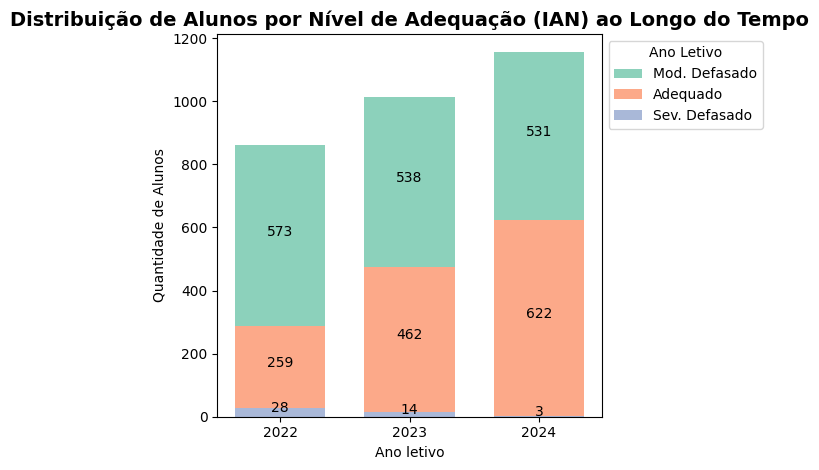

In [74]:
# 1. Preparação: Filtramos os dados para garantir que temos as colunas necessárias preenchidas
df_ian = df_unificado.dropna(subset=['IAN']).copy() # Remove registros com valores nulos no indicador para garantir que a análise seja fidedigna

# 2. Aplica a função para criar a coluna de descrição
df_ian['IAN_Descricao'] = df_ian['IAN'].apply(lambda x: classificar_indicador(x, 'IAN')) # Cria uma nova coluna no DataFrame aplicando a lógica de rotulação da função mestra

# 3. Define a ordem lógica das categorias para o gráfico
ordem = ['Sev. Defasado', 'Mod. Defasado', 'Adequado'] # Lista a sequência desejada para que o gráfico siga uma hierarquia de evolução

# --- GRÁFICO ÚNICO: DISTRIBUIÇÃO DE ADEQUAÇÃO (IAN) ---
# 4. Cria o gráfico de contagem agrupado por ANO, usando a paleta Set2 e a ordem definida
ax = sns.histplot(data=df_ian, x='ANO', hue='IAN_Descricao', multiple='stack', palette='Set2', shrink=0.7, linewidth=0, discrete=True) # Gera um histograma empilhado para mostrar a proporção de cada nível por ano

# 5. Adiciona o rótulo de dados (contagem absoluta) em cima de cada barra
for container in ax.containers: # Percorre as subdivisões das barras empilhadas geradas no gráfico
    ax.bar_label(container, label_type='center', fontsize=10, padding=3) # Insere o número de alunos dentro de cada segmento da barra para facilitar a análise quantitativa

# 6. Personalização de títulos e eixos
plt.title('Distribuição de Alunos por Nível de Adequação (IAN) ao Longo do Tempo', fontsize=14, fontweight='bold') # Define o título principal com formatação em negrito e destaque visual
plt.xlabel('Ano letivo') # Atribui o nome descritivo para o eixo horizontal (tempo)
plt.ylabel('Quantidade de Alunos') # Atribui o nome descritivo para o eixo vertical (volume de estudantes)

# 7. Ajustando a legenda
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='Ano Letivo') # Posiciona a legenda fora da área do gráfico para não obstruir a visualização das barras

# 8. FINALIZAÇÃO DO LAYOUT
plt.tight_layout() # Ajusta automaticamente o espaçamento dos elementos para que nada seja cortado na renderização final
plt.show() # Renderiza e exibe o gráfico finalizado na tela

A jornada de qualquer aluno começa pela correção da sua rota escolar. 
O IAN monitora se o aluno está na série correta para sua idade — a base necessária para que todos os outros indicadores floresçam.
O perfil de defasagem dos alunos apresenta uma trajetória de melhora consistente e estrutural, indicando que a estratégia de nivelamento da associação está a colher frutos sólidos.
- **Melhoria na Adequação:** A percentagem de alunos em nível adequado saltou de $30,1\%$ em $2022$ para $53,8\%$ em $2024$. Este aumento de mais de $23$ pontos percentuais mostra uma eficiência notável na regularização do fluxo escolar.
- **Redução da Defasagem Moderada:** O índice de atraso moderado (alunos $1$ ou $2$ anos fora da série ideal) caiu de $66,6\%$ para $45,9\%$.
- **Erradicação da Defasagem Severa:** Houve uma queda drástica de $3,2\%$ para apenas $0,2\%$. Isso significa que o risco de abandono escolar por distorção idade-série extrema foi virtualmente eliminado na base atendida.

##### 2. Desempenho acadêmico (IDA): O desempenho acadêmico médio (IDA) está melhorando, estagnado ou caindo ao longo das fases e anos?

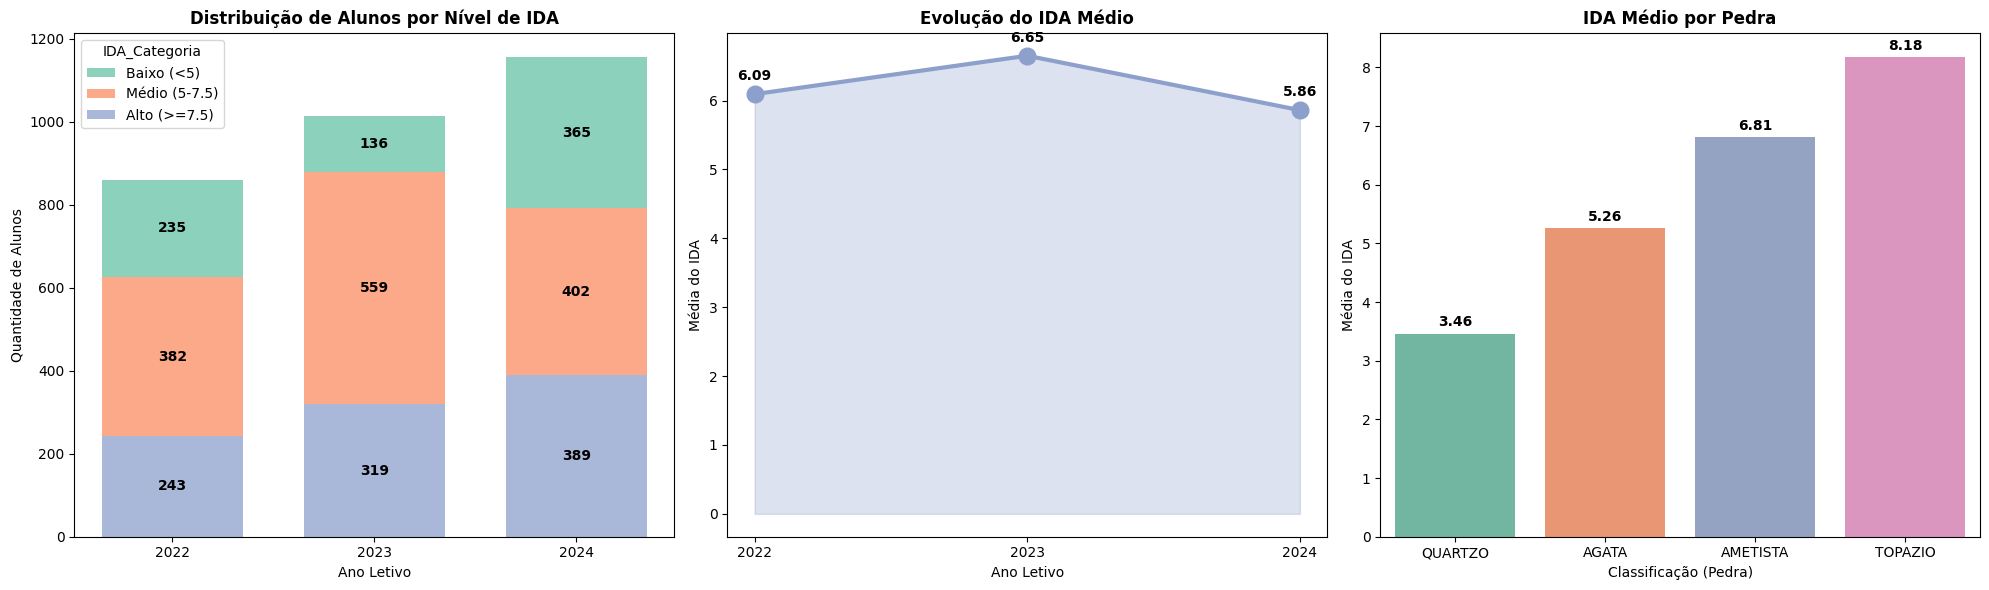

In [75]:
# 1. Preparação: Filtramos os dados para garantir que temos as colunas necessárias preenchidas
df_ida = df_unificado.dropna(subset=['IDA']).copy() # Remove registros com valores nulos no indicador para garantir que a análise seja fidedigna

# 2. Aplica a função para criar a coluna de descrição
df_ida['IDA_Categoria'] = df_ida['IDA'].apply(lambda x: classificar_indicador(x, 'IDA')) # Cria uma nova coluna no DataFrame aplicando a lógica de rotulação da função mestra
ordem_ida = ['Baixo (<5)', 'Médio (5-7.5)', 'Alto (>=7.5)'] # Lista a sequência desejada para que o gráfico siga uma hierarquia de evolução

# 3. Início da Figura: Criamos uma área para 3 gráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # Inicializa uma moldura com três espaços de plotagem para uma análise 360º do indicador

# --- GRÁFICO 1: DISTRIBUIÇÃO CATEGÓRICA (Histplot) ---
# Mostra a quantidade de alunos em cada nível de desempenho por ano
ax0 = sns.histplot(data=df_ida, x='ANO', hue='IDA_Categoria', hue_order=ordem_ida,
                  multiple='stack', palette='Set2', shrink=0.7, linewidth=0, discrete=True, ax=axes[0]) # Plota a composição volumétrica dos níveis no primeiro eixo
for container in ax0.containers: # Itera sobre cada segmento empilhado das barras no primeiro gráfico
    ax0.bar_label(container, label_type='center', fontsize=10, fontweight='bold') # Posiciona o número absoluto de alunos no centro de cada cor da barra no primeiro gráfico
axes[0].set_title('Distribuição de Alunos por Nível de IDA', fontweight='bold') # Atribui o título descritivo para a análise de distribuição temporal no primeiro gráfico
axes[0].set_xlabel('Ano Letivo') # Define o rótulo do eixo horizontal para o primeiro gráfico
axes[0].set_ylabel('Quantidade de Alunos') # Define o rótulo do eixo vertical para o primeiro gráfico
axes[0].grid(False) # Desativa a grade de fundo para manter o padrão visual limpo no primeiro gráfico

# --- GRÁFICO 2: EVOLUÇÃO DA MÉDIA (Lineplot) ---
# Plota a média anual do IDA para observar a tendência
media_ida = df_ida.groupby('ANO')['IDA'].mean() # Agrupa os dados por ano e calcula o valor médio do indicador para o segundo gráfico
axes[1].plot(media_ida.index, media_ida.values, marker='o', linewidth=3, markersize=12, color= sns.color_palette("Set2")[2]) # Desenha uma linha de tendência com marcadores destacados no segundo eixo
axes[1].fill_between(media_ida.index, media_ida.values, alpha=0.3, color= sns.color_palette("Set2")[2]) # Adiciona o preenchimento colorido abaixo da linha para realçar a área do segundo gráfico
for x, y in zip(media_ida.index, media_ida.values): # Itera sobre as coordenadas de cada ponto da linha de tendência
    axes[1].annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0, 10), ha='center', fontweight='bold') # Adiciona o valor exato da média acima de cada ponto do segundo gráfico
axes[1].set_title('Evolução do IDA Médio', fontweight='bold') # Atribui o título do segundo gráfico focado na tendência temporal das médias
axes[1].set_xlabel('Ano Letivo') # Define o rótulo do eixo horizontal para o segundo gráfico
axes[1].set_ylabel('Média do IDA') # Define o rótulo do eixo vertical para o segundo gráfico
axes[1].set_xticks(media_ida.index) # Garante que as marcações do eixo X correspondam exatamente aos anos no segundo gráfico
axes[1].grid(False) # Desativa a grade de fundo para o segundo gráfico

# --- GRÁFICO 3: DESEMPENHO POR PEDRA (Barplot) ---
# Mostra a relação entre a maturidade (Pedra) e o desempenho médio
ordem_pedras = ['QUARTZO', 'AGATA', 'AMETISTA', 'TOPAZIO'] 
ida_pedra = df_ida.groupby('PEDRA')['IDA'].mean().reindex([p for p in ordem_pedras if p in df_ida['PEDRA'].unique()]) # Calcula a média do indicador para cada classificação de pedra no terceiro gráfico
ax2 = sns.barplot(x=ida_pedra.index, y=ida_pedra.values, palette='Set2', ax=axes[2], edgecolor='none') # Gera um gráfico de barras comparativo no terceiro eixo
for container in ax2.containers: # Itera sobre as barras do terceiro gráfico
    ax2.bar_label(container, fmt='%.2f', padding=3, fontweight='bold') # Insere os rótulos de média sobre cada barra do terceiro gráfico
axes[2].set_title('IDA Médio por Pedra', fontweight='bold') # Atribui o título do terceiro gráfico destacando a correlação com a classificação 'Pedra'
axes[2].set_xlabel('Classificação (Pedra)') # Define o rótulo do eixo horizontal para o terceiro gráfico
axes[2].set_ylabel('Média do IDA') # Define o rótulo do eixo vertical para o terceiro gráfico
axes[2].grid(False) # Desativa a grade de fundo para o terceiro gráfico

# 4. FINALIZAÇÃO DO LAYOUT
plt.tight_layout() # Recalcula automaticamente as margens para que os três subplots e seus elementos não se sobreponham
plt.show() # Renderiza a figura completa com os três gráficos informativos

Nivelar o aluno é o primeiro passo, mas garantir que ele aprenda de forma contínua é um desafio dinâmico. 
Os dados revelam que 2024 trouxe novos obstáculos pedagógicos.O desempenho acadêmico médio (IDA) revela uma oscilação importante que exige uma análise cuidadosa sobre a retenção do conhecimento.
- **O Pico e a Retração:** A média do IDA subiu de $6,09$ ($2022$) para um excelente $6,65$ ($2023$), porém sofreu uma piora em 2024, recuando para $5,86$. Esta queda sugere que o aumento da complexidade das fases ou a entrada de novos alunos com lacunas de base impactou a média global.
- **Polarização e Desigualdade:** Enquanto o grupo de elite ($\geq 7,5$) cresceu para $33,6\%$, o grupo de desempenho baixo ($<5$) também voltou a subir em $2024$ ($31,5\%$). O modelo aponta para uma "fenda" onde os alunos que não consolidaram a base estão a ter dificuldade em acompanhar o ritmo.
- **Diferencial por Pedra:** Alunos Topázio (os mais maduros no projeto) mantêm a estabilidade com média $8,18$, enquanto os Quartzo (iniciantes) lutam com a base em $3,46$, reforçando que o tempo de permanência é o maior antídoto contra a baixa nota.

##### 3. Engajamento nas atividades (IEG): O grau de engajamento dos alunos (IEG) tem relação direta com seus indicadores de desempenho (IDA) e do ponto de virada (IPV)?

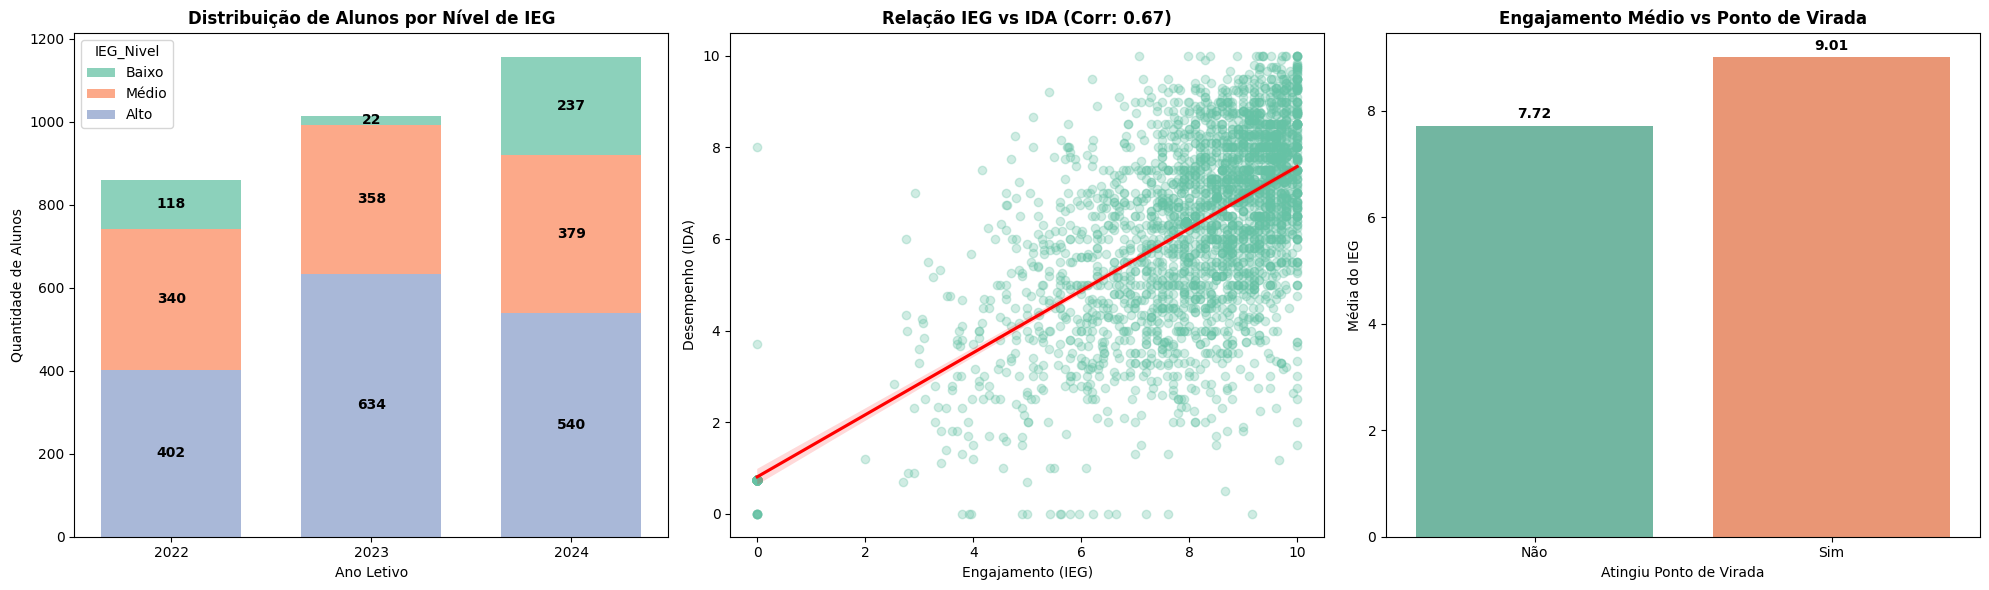

In [64]:
# 1. Preparação: Filtramos os dados para garantir que temos as colunas necessárias preenchidas
df_ieg = df_unificado.dropna(subset=['IEG', 'IDA']).copy() # Remove registros com valores nulos no indicador para garantir que a análise seja fidedigna

# 2. Aplica a função para criar a coluna de descrição
df_ieg['IEG_Nivel'] = df_ieg['IEG'].apply(lambda x: classificar_indicador(x, 'IEG')) # Cria uma nova coluna no DataFrame aplicando a lógica de rotulação da função mestra
ordem_ieg = ['Baixo', 'Médio', 'Alto'] # Lista a sequência desejada para que o gráfico siga uma hierarquia de evolução

# 3. Início da Figura: Criamos uma área para 3 gráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # Inicializa uma moldura com três espaços de plotagem para uma análise 360º do indicador

# --- GRÁFICO 1: DISTRIBUIÇÃO CATEGÓRICA (Histplot) ---
# Mostra a quantidade de alunos em cada nível de engajamento por ano
ax0 = sns.histplot(data=df_ieg, x='ANO', hue='IEG_Nivel', hue_order=ordem_ieg,
                  multiple='stack', palette='Set2', shrink=0.7, linewidth=0, discrete=True, ax=axes[0]) # Plota a composição volumétrica dos níveis no primeiro eixo
for container in ax0.containers: # Itera sobre cada segmento empilhado das barras no primeiro gráfico
    ax0.bar_label(container, label_type='center', fontsize=10, fontweight='bold') # Posiciona o número absoluto de alunos no centro de cada cor da barra no primeiro gráfico
axes[0].set_title('Distribuição de Alunos por Nível de IEG', fontweight='bold') # Atribui o título descritivo para a análise de distribuição temporal no primeiro gráfico
axes[0].set_xlabel('Ano Letivo') # Define o rótulo do eixo horizontal para o primeiro gráfico
axes[0].set_ylabel('Quantidade de Alunos') # Define o rótulo do eixo vertical para o primeiro gráfico
axes[0].grid(False) # Desativa a grade de fundo para manter o padrão visual limpo no primeiro gráfico

# --- GRÁFICO 2: RELAÇÃO IEG vs DESEMPENHO (Regplot) ---
# Gráfico de dispersão com linha de regressão para mostrar a correlação
corr_ieg_ida, _ = stats.pearsonr(df_ieg['IEG'], df_ieg['IDA']) # Calcula o coeficiente de correlação de Pearson para medir a força da associação entre engajamento e desempenho acadêmico
sns.regplot(data=df_ieg, x='IEG', y='IDA', scatter_kws={'alpha':0.3,  'color': sns.color_palette("Set2")[0]}, 
            line_kws={'color':'red'}, ax=axes[1]) # Desenha o gráfico de dispersão com uma linha de tendência central no segundo eixo
axes[1].set_title(f'Relação IEG vs IDA (Corr: {corr_ieg_ida:.2f})', fontweight='bold') # Atribui o título do segundo gráfico destacando a influência do engajamento nas notas e a correlação
axes[1].set_xlabel('Engajamento (IEG)') # Define o rótulo do eixo horizontal para o segundo gráfico
axes[1].set_ylabel('Desempenho (IDA)') # Define o rótulo do eixo vertical para o segundo gráfico
axes[1].grid(False) # Desativa a grade de fundo para o segundo gráfico

# --- GRÁFICO 3: ENGAJAMENTO MÉDIO POR PONTO DE VIRADA (Barplot) ---
# Mostra a relação entre o Ponto de Virada e o engajamento médio
df_pv = df_unificado.dropna(subset=['IEG', 'PONTO_VIRADA']) # Prepara um conjunto de dados removendo valores nulos das colunas de engajamento e ponto de virada
ieg_pv_media = df_pv.groupby('PONTO_VIRADA')['IEG'].mean().reset_index() # Agrupa os dados e calcula a média de engajamento para quem atingiu ou não o ponto de virada
ax2 = sns.barplot(data=ieg_pv_media, x='PONTO_VIRADA', y='IEG', palette='Set2', ax=axes[2]) # Gera um gráfico de barras comparativo no terceiro eixo
for container in ax2.containers: # Itera sobre as barras do terceiro gráfico
    ax2.bar_label(container, fmt='%.2f', padding=3, fontweight='bold') # Insere os rótulos de média sobre cada barra do terceiro gráfico
axes[2].set_title('Engajamento Médio vs Ponto de Virada', fontweight='bold') # Atribui o título do terceiro gráfico relacionando o IEG com o sucesso do aluno
axes[2].set_xlabel('Atingiu Ponto de Virada') # Define o rótulo do eixo horizontal para o terceiro gráfico
axes[2].set_ylabel('Média do IEG') # Define o rótulo do eixo vertical para o terceiro gráfico
axes[2].grid(False) # Desativa a grade de fundo para o terceiro gráfico
for patch in ax2.patches: patch.set_edgecolor('none') # Remove os contornos das barras no terceiro gráfico para suavizar a estética

# 4. FINALIZAÇÃO DO LAYOUT
plt.tight_layout() # Recalcula automaticamente as margens para que os três subplots e seus elementos não se sobreponham
plt.show() # Renderiza a figura completa com os três gráficos informativos

Mesmo quando as notas oscilam, o engajamento é o comportamento que mantém o aluno "vivo" no sistema. 
É o indicador que prevê quem conseguirá recuperar as notas baixas.O grau de engajamento (IEG) mantém uma conexão vital com o desempenho, funcionando como o principal motor de resiliência.
- **Resiliência do Esforço:** Apesar da queda no IDA em $2024$, o engajamento médio continua a ser o grande diferencial. Alunos que atingiram o "Ponto de Virada" mantêm um IEG de $9,01$, provando que a disciplina precede a nota.
- **Alavanca de Recuperação:** Com uma forte correlação de $0,67$ com o IDA, o modelo sugere que focar no engajamento é a estratégia mais rápida para reverter a piora nas notas observada no último ano.
- **Sinal de Alerta:** Alunos que não atingiram a virada apresentam engajamento inferior ($7,62$), o que cria um ciclo vicioso: menos esforço leva a notas menores, dificultando a progressão de "Pedra".

##### 4. Autoavaliação (IAA): As percepções dos alunos sobre si mesmos (IAA) são coerentes com seu desempenho real (IDA) e engajamento (IEG)?

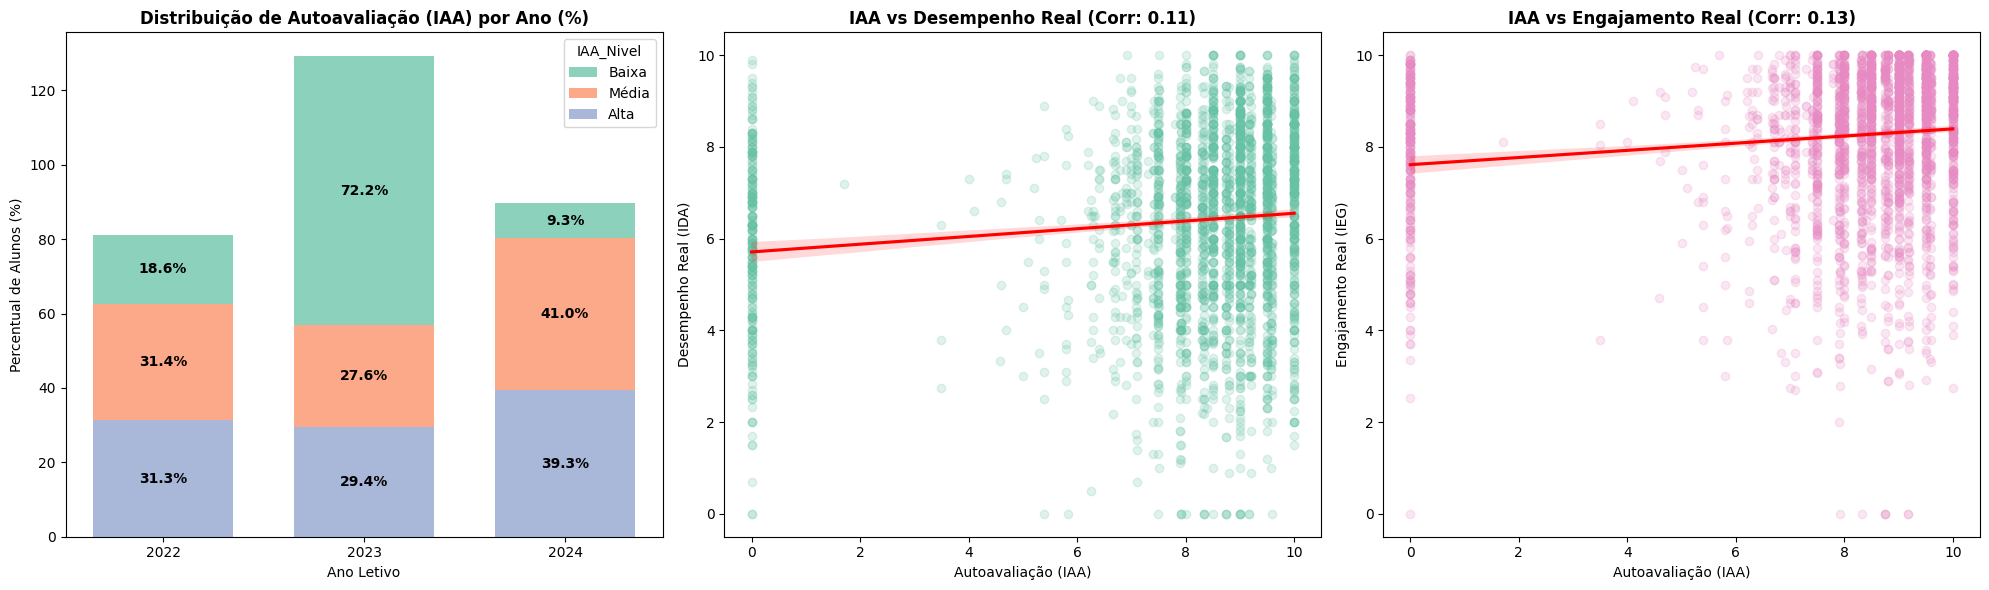

In [63]:
# 1. Preparação: Filtramos os dados para garantir que temos as colunas necessárias preenchidas
df_iaa = df_unificado.dropna(subset=['IAA', 'IDA', 'IEG']).copy() # Remove registros com valores nulos no indicador para garantir que a análise seja fidedigna

# 2. Aplica a função para criar a coluna de descrição
df_iaa['IAA_Nivel'] = df_iaa['IAA'].apply(lambda x: classificar_indicador(x, 'IAA')) # Cria uma nova coluna no DataFrame aplicando a lógica de rotulação da função mestra
ordem_iaa = ['Baixa', 'Média', 'Alta'] # Lista a sequência desejada para que o gráfico siga uma hierarquia de evolução

# 3. Início da Figura: Criamos uma área para 3 gráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # Inicializa uma moldura com três espaços de plotagem para uma análise 360º do indicador

# --- GRÁFICO 1: DISTRIBUIÇÃO CATEGÓRICA (Histplot) ---
# Mostra a quantidade de alunos em cada nível de autoavaliação por ano
ax0 = sns.histplot(data=df_iaa, x='ANO', hue='IAA_Nivel', hue_order=ordem_iaa,
                  multiple='stack', palette='Set2', shrink=0.7, linewidth=0,
                  discrete=True, stat='percent', common_norm=False, ax=axes[0]) # Plota a composição volumétrica dos níveis no primeiro eixo
for container in ax0.containers: # Itera sobre cada segmento empilhado das barras no primeiro gráfico
    ax0.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, fontweight='bold') # Posiciona o valor percentual formatado no centro de cada cor da barra no primeiro gráfico
axes[0].set_title('Distribuição de Autoavaliação (IAA) por Ano (%)', fontweight='bold') # Atribui o título descritivo para a análise de distribuição temporal no primeiro gráfico
axes[0].set_xlabel('Ano Letivo') # Define o rótulo do eixo horizontal para o primeiro gráfico
axes[0].set_ylabel('Percentual de Alunos (%)') # Define o rótulo do eixo vertical para o primeiro gráfico
axes[0].grid(False) # Desativa a grade de fundo para manter o padrão visual limpo no primeiro gráfico

# --- GRÁFICO 2: AUTOAVALIAÇÃO vs DESEMPENHO REAL (Regplot) ---
# Gráfico de dispersão com linha de regressão para mostrar a correlação
corr_iaa_ida, _ = stats.pearsonr(df_iaa['IAA'], df_iaa['IDA']) # Calcula o coeficiente de correlação de Pearson para medir o alinhamento entre a percepção do aluno e sua nota real
sns.regplot(data=df_iaa, x='IAA', y='IDA', scatter_kws={'alpha':0.2, 'color': sns.color_palette("Set2")[0]},
            line_kws={'color':'red'}, ax=axes[1]) # Desenha o gráfico de dispersão com uma linha de tendência central no segundo eixo
axes[1].set_title(f'IAA vs Desempenho Real (Corr: {corr_iaa_ida:.2f})', fontweight='bold') # Atribui o título do segundo gráfico incluindo o coeficiente de correlação IAA-IDA
axes[1].set_xlabel('Autoavaliação (IAA)') # Define o rótulo do eixo horizontal para o segundo gráfico
axes[1].set_ylabel('Desempenho Real (IDA)') # Define o rótulo do eixo vertical para o segundo gráfico
axes[1].grid(False) # Desativa a grade de fundo para o segundo gráfico

# --- GRÁFICO 3: AUTOAVALIAÇÃO vs ENGAJAMENTO REAL (Regplot) ---
# Gráfico de dispersão com linha de regressão para mostrar a correlação
corr_iaa_ieg, _ = stats.pearsonr(df_iaa['IAA'], df_iaa['IEG']) # Calcula o coeficiente de correlação entre a autoavaliação e o nível de engajamento efetivo medido pelos professores
sns.regplot(data=df_iaa, x='IAA', y='IEG', scatter_kws={'alpha':0.2, 'color': sns.color_palette("Set2")[3]},
            line_kws={'color':'red'}, ax=axes[2]) # Desenha o gráfico de dispersão com uma linha de tendência central no terceiro eixo
axes[2].set_title(f'IAA vs Engajamento Real (Corr: {corr_iaa_ieg:.2f})', fontweight='bold') # Atribui o título do terceiro gráfico incluindo o coeficiente de correlação IAA-IEG
axes[2].set_xlabel('Autoavaliação (IAA)') # Define o rótulo do eixo horizontal para o terceiro gráfico
axes[2].set_ylabel('Engajamento Real (IEG)') # Define o rótulo do eixo vertical para o terceiro gráfico
axes[2].grid(False) # Desativa a grade de fundo para o segundo gráfico

# 4. FINALIZAÇÃO DO LAYOUT
plt.tight_layout() # Recalcula automaticamente as margens para que os três subplots e seus elementos não se sobreponham
plt.show() # Renderiza a figura completa com os três gráficos informativos

Um dos pontos mais sensíveis da análise: como o aluno se percebe. 
Existe um otimismo que, se não for mediado, pode mascarar a necessidade de reforço escolar.A autoavaliação (IAA) mostra uma estabilidade perigosa em níveis altos, revelando um descolamento crítico da realidade acadêmica.
- **Otimismo Estático:** Impressionantes $82,1\%$ dos alunos avaliam o seu próprio desempenho como "Alto", independentemente da queda real vista no IDA em $2024$.
- **Falta de Autocrítica Técnica:** A baixíssima correlação com o IDA ($0,11$) indica que o aluno não percebe a piora no seu desempenho técnico. Ele sente-se capaz, mas essa percepção não está a converter-se em notas, o que pode gerar frustração futura.
- **Cultura vs. Dados:** Embora a autoconfiança seja um valor central da Passos Mágicos, o modelo sugere a necessidade de alinhar a percepção do aluno com os seus resultados reais para gerar um senso de urgência no estudo.

##### 5. Aspectos psicossociais (IPS): Há padrões psicossociais (IPS) que antecedem quedas de desempenho acadêmico ou de engajamento?

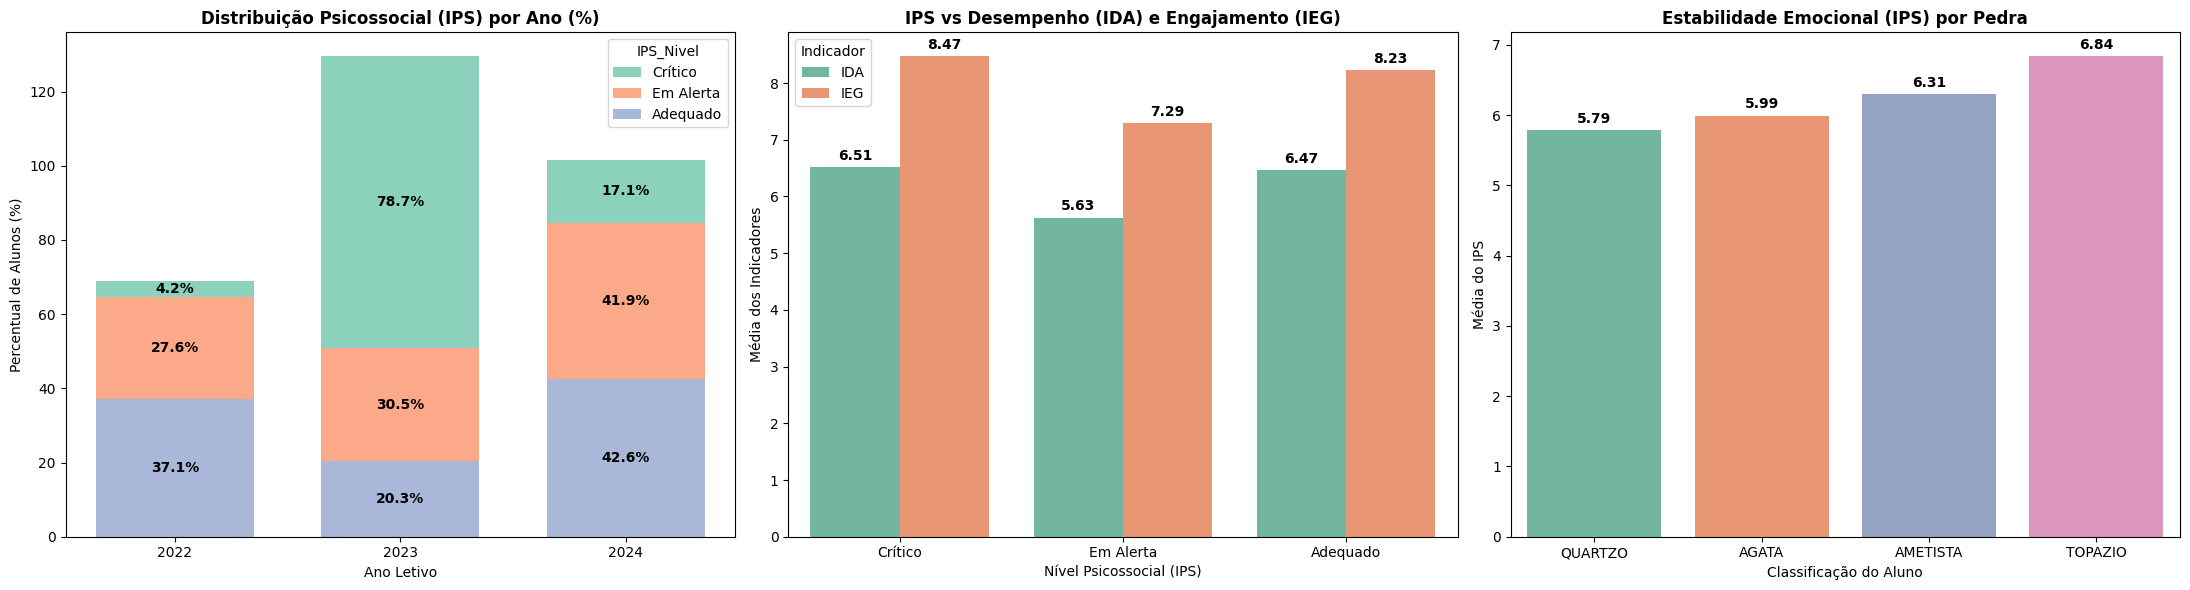

In [27]:
# 1. Preparação: Filtramos os dados para garantir que temos as colunas necessárias preenchidas
df_ips = df_unificado.dropna(subset=['IPS', 'IDA', 'IEG']).copy() # Remove registros com valores nulos no indicador para garantir que a análise seja fidedigna

# 2. Aplica a função para criar a coluna de descrição
df_ips['IPS_Nivel'] = df_ips['IPS'].apply(lambda x: classificar_indicador(x, 'IPS')) # Cria uma nova coluna no DataFrame aplicando a lógica de rotulação da função mestra
ordem_ips = ['Crítico', 'Em Alerta', 'Adequado'] # Lista a sequência desejada para que o gráfico siga uma hierarquia de evolução

# 3. Início da Figura: Criamos uma área para 3 gráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(22, 6)) # Inicializa uma moldura com três espaços de plotagem para uma análise 360º do indicador

# --- GRÁFICO 1: DISTRIBUIÇÃO CATEGÓRICA (Histplot) ---
# Mostra a quantidade de alunos em cada nível psicossocial por ano
ax0 = sns.histplot(data=df_ips, x='ANO', hue='IPS_Nivel', hue_order=ordem_ips,
                  multiple='stack', palette='Set2', shrink=0.7, linewidth=0,
                  discrete=True, stat='percent', common_norm=False, ax=axes[0]) # Plota a composição volumétrica dos níveis no primeiro eixo
for container in ax0.containers: # Itera sobre cada segmento empilhado das barras no primeiro gráfico
    ax0.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, fontweight='bold') # Posiciona o valor percentual formatado no centro de cada cor da barra no primeiro gráfico
axes[0].set_title('Distribuição Psicossocial (IPS) por Ano (%)', fontweight='bold') # Atribui o título descritivo para a análise de distribuição temporal no primeiro gráfico
axes[0].set_xlabel('Ano Letivo') # Define o rótulo do eixo horizontal para o primeiro gráfico
axes[0].set_ylabel('Percentual de Alunos (%)') # Define o rótulo do eixo vertical para o primeiro gráfico
axes[0].grid(False) # Desativa a grade de fundo para manter o padrão visual limpo no primeiro gráfico

# --- GRÁFICO 2: IPS vs DESEMPENHO E ENGAJAMENTO (Barplot) ---
# Mostra o impacto do nível psicossocial nas médias acadêmicas
df_rel = df_ips.groupby('IPS_Nivel')[['IDA', 'IEG']].mean().reindex(ordem_ips).reset_index() # Agrupa os dados e calcula as médias dos indicadores para o segundo gráfico
df_melt = df_rel.melt(id_vars='IPS_Nivel', var_name='Indicador', value_name='Média') # Transforma os dados em formato longo para a plotagem das barras agrupadas
ax1 = sns.barplot(data=df_melt, x='IPS_Nivel', y='Média', hue='Indicador', palette='Set2', ax=axes[1]) # Desenha barras comparativas entre IDA e IEG para cada nível de IPS no segundo eixo
for container in ax1.containers: # Itera sobre as barras de indicadores no segundo gráfico
    ax1.bar_label(container, fmt='%.2f', padding=3, fontweight='bold') # Insere os rótulos de média acima de cada barra no segundo gráfico
axes[1].set_title('IPS vs Desempenho (IDA) e Engajamento (IEG)', fontweight='bold') # Atribui o título do segundo gráfico correlacionando estado emocional com métricas
axes[1].set_xlabel('Nível Psicossocial (IPS)') # Define o rótulo do eixo horizontal para o segundo gráfico
axes[1].set_ylabel('Média dos Indicadores') # Define o rótulo do eixo vertical para o segundo gráfico
axes[1].grid(False) # Desativa a grade de fundo para o segundo gráfico
for patch in ax1.patches: patch.set_edgecolor('none') # Remove os contornos das barras no segundo gráfico para suavizar a estética

# --- GRÁFICO 3: ESTABILIDADE EMOCIONAL POR PEDRA (Barplot) ---
# Mostra a evolução do IPS conforme a maturidade do aluno
ordem_pedras = ['QUARTZO', 'AGATA', 'AMETISTA', 'TOPAZIO'] # Define a hierarquia oficial das pedras para o eixo horizontal do terceiro gráfico
ips_pedra_df = df_ips.groupby('PEDRA')['IPS'].mean().reindex(ordem_pedras).reset_index() # Calcula a média do IPS para cada classificação de pedra no terceiro gráfico
ax2 = sns.barplot(data=ips_pedra_df, x='PEDRA', y='IPS', palette='Set2', ax=axes[2]) # Plota a evolução do bem-estar conforme a maturidade no terceiro eixo
for container in ax2.containers: # Itera sobre as barras do terceiro gráfico
    ax2.bar_label(container, fmt='%.2f', padding=3, fontweight='bold') # Insere os rótulos de média do IPS sobre cada barra do terceiro gráfico
axes[2].set_title('Estabilidade Emocional (IPS) por Pedra', fontweight='bold') # Atribui o título do terceiro gráfico destacando a evolução emocional
axes[2].set_xlabel('Classificação do Aluno') # Define o rótulo do eixo horizontal para o terceiro gráfico
axes[2].set_ylabel('Média do IPS') # Define o rótulo do eixo vertical para o terceiro gráfico
axes[2].grid(False) # Desativa a grade de fundo para o terceiro gráfico
for patch in ax2.patches: patch.set_edgecolor('none') # Remove os contornos das barras no terceiro gráfico para suavizar a estética

# 4. FINALIZAÇÃO DO LAYOUT
plt.tight_layout() # Recalcula automaticamente as margens para que os três subplots e seus elementos não se sobreponham
plt.show() # Renderiza a figura completa com os três gráficos informativos

O IPS monitora a saúde emocional e social. 
Em anos de oscilação acadêmica, um IPS forte é o que impede que o aluno desista do projeto.O padrão psicossocial (IPS) evolui com o tempo de projeto, servindo como um amortecedor para as pressões do aprendizado e da vida externa.
- **Evolução da Resiliência:** A média do IPS melhora conforme a Pedra: de $5,79$ (Quartzo) a $6,83$ (Topázio). Isso prova que o projeto fortalece o indivíduo além da sala de aula.
- **Vulnerabilidade e Notas:** Alunos em nível "Em Alerta" no IPS apresentam desempenho acadêmico visivelmente inferior ($5,62$). O modelo confirma que a instabilidade emocional é, muitas vezes, a causa raiz da piora no IDA e no IEG.

##### 6. Aspectos psicopedagógicos (IPP): As avaliações psicopedagógicas (IPP) confirmam ou contradizem a defasagem identificada pelo IAN?

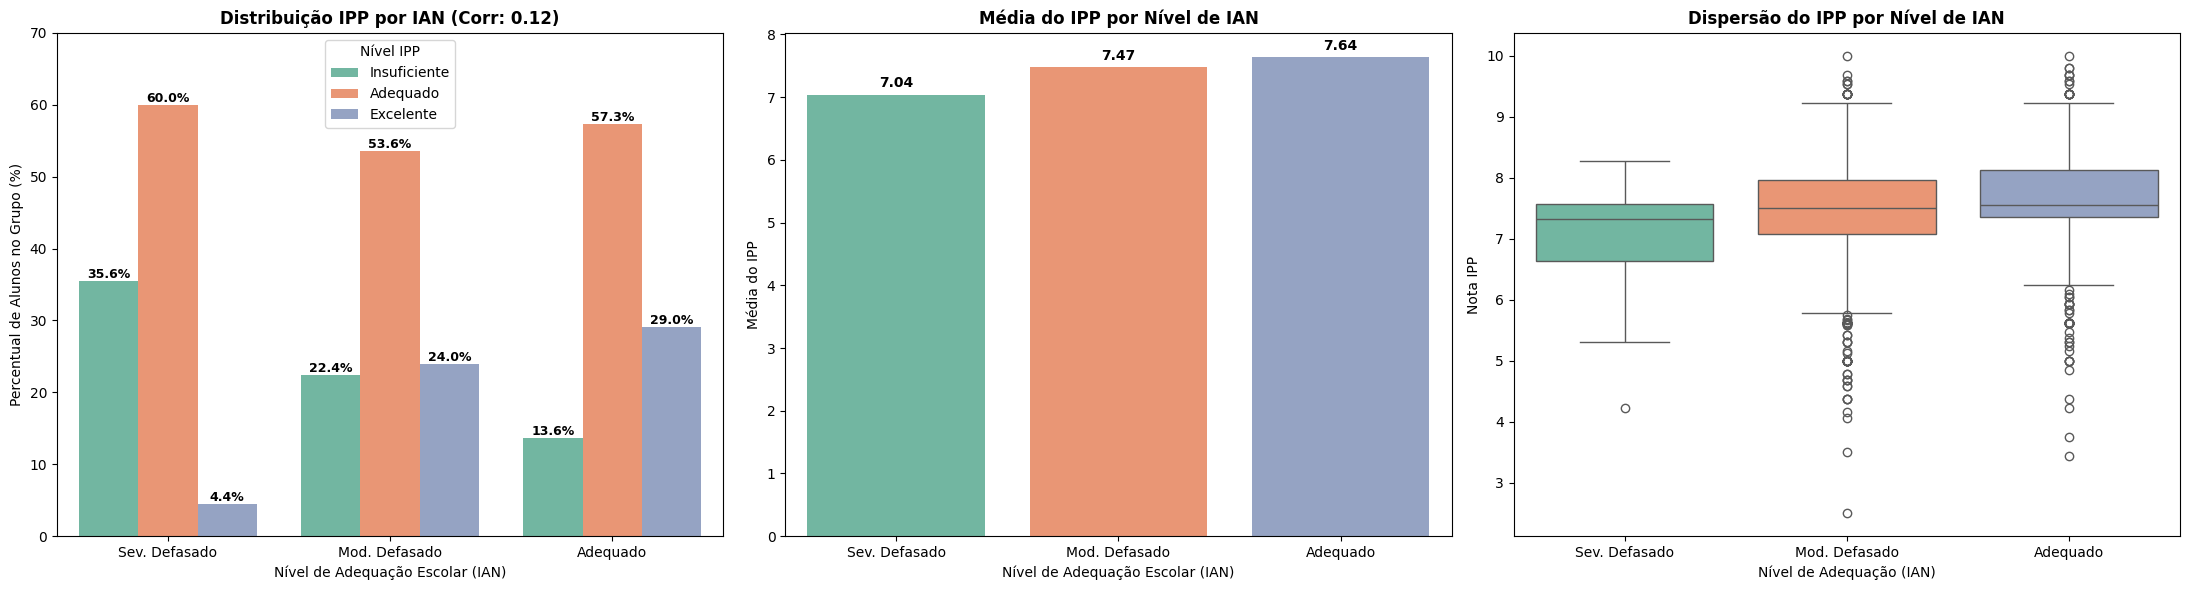

In [28]:
# 1. Preparação: Filtramos os dados para garantir que temos as colunas necessárias preenchidas
df_ipp = df_unificado.dropna(subset=['IPP', 'IAN']).copy() # Remove registros com valores nulos no indicador para garantir que a análise seja fidedigna

# 2. Aplica a função para criar a coluna de descrição
df_ipp['IAN_Descricao'] = df_ipp['IAN'].apply(lambda x: classificar_indicador(x, 'IAN')) # Cria uma nova coluna no DataFrame aplicando a lógica de rotulação da função mestra
df_ipp['IPP_Nivel'] = df_ipp['IPP'].apply(lambda x: classificar_indicador(x, 'IPP')) # Cria uma nova coluna para o nível de IPP usando a função mestra
ordem_ian = ['Sev. Defasado', 'Mod. Defasado', 'Adequado'] # Lista a sequência desejada para que o gráfico siga uma hierarquia de evolução
ordem_ipp = ['Insuficiente', 'Adequado', 'Excelente'] # Estabelece a sequência hierárquica para as categorias psicopedagógicas

# 3. Início da Figura: Criamos uma área para 3 gráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(22, 6)) # Inicializa uma moldura com três espaços de plotagem para uma análise 360º do indicador

# --- GRÁFICO 1: DISTRIBUIÇÃO CATEGÓRICA (Barplot) ---
# Mostra a quantidade de alunos em cada nível psicopedagógico por nível de IAN
df_plot = pd.crosstab(df_ipp['IAN_Descricao'], df_ipp['IPP_Nivel'], normalize='index').reset_index() # Gera matriz de frequência relativa para comparação percentual entre as categorias
df_plot = df_plot.melt(id_vars='IAN_Descricao', var_name='Nível IPP', value_name='Percentual') # Reorganiza dados para o formato longo para a plotagem das barras agrupadas
df_plot['Percentual'] = df_plot['Percentual'] * 100 # Converte os valores decimais para a escala percentual de zero a cem

ax0 = sns.barplot(data=df_plot, x='IAN_Descricao', y='Percentual', order=ordem_ian,
                 hue='Nível IPP', hue_order=ordem_ipp, palette='Set2', ax=axes[0]) # Plota a composição volumétrica dos níveis no primeiro eixo
for container in ax0.containers: # Itera sobre cada segmento empilhado das barras no primeiro gráfico
    ax0.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=9, fontweight='bold') # Posiciona o número absoluto de alunos no centro de cada cor da barra no primeiro gráfico

corr_ipp_ian, _ = stats.pearsonr(df_ipp['IPP'], df_ipp['IAN']) # Calcula o coeficiente de correlação de Pearson para medir a força da associação entre as variáveis
axes[0].set_title(f'Distribuição IPP por IAN (Corr: {corr_ipp_ian:.2f})', fontweight='bold') # Atribui o título descritivo para a análise de distribuição temporal no primeiro gráfico
axes[0].set_xlabel('Nível de Adequação Escolar (IAN)') # Define o rótulo do eixo horizontal para o primeiro gráfico
axes[0].set_ylabel('Percentual de Alunos no Grupo (%)') # Define o rótulo do eixo vertical para o primeiro gráfico
axes[0].set_ylim(0, 70) # Ajusta o limite para os rótulos não serem cortados no primeiro gráfico
axes[0].grid(False) # Desativa a grade de fundo para manter o padrão visual limpo no primeiro gráfico

# --- GRÁFICO 2: MÉDIA DO IPP POR NÍVEL DE IAN (Barplot) ---
# Calcula a média aritmética do IPP para confirmar a tendência de crescimento
ipp_por_ian = df_ipp.groupby('IAN_Descricao')['IPP'].mean().reindex(ordem_ian).reset_index() # Agrupa os dados e calcula as médias dos indicadores para o segundo gráfico
ax1 = sns.barplot(data=ipp_por_ian, x='IAN_Descricao', y='IPP', palette='Set2', ax=axes[1]) # Desenha barras comparativas entre os indicadores no segundo eixo
for container in ax1.containers: # Itera sobre as barras de indicadores no segundo gráfico
    ax1.bar_label(container, fmt='%.2f', padding=3, fontweight='bold') # Insere os rótulos de média acima de cada barra no segundo gráfico

axes[1].set_title('Média do IPP por Nível de IAN', fontweight='bold') # Atribui o título do segundo gráfico correlacionando estado emocional com métricas
axes[1].set_xlabel('Nível de Adequação Escolar (IAN)') # Define o rótulo do eixo horizontal para o segundo gráfico
axes[1].set_ylabel('Média do IPP') # Define o rótulo do eixo vertical para o segundo gráfico
axes[1].grid(False) # Desativa a grade de fundo para o segundo gráfico
for patch in ax1.patches: patch.set_edgecolor('none') # Remove os contornos das barras no segundo gráfico para suavizar a estética

# --- GRÁFICO 3: DISPERSÃO DO IPP POR IAN (Boxplot) ---
# O Boxplot visualiza a variação e os casos excepcionais de alto potencial
sns.boxplot(data=df_ipp, x='IAN_Descricao', y='IPP', order=ordem_ian, palette='Set2', ax=axes[2]) # Plota a evolução do bem-estar conforme a maturidade no terceiro eixo
axes[2].set_title('Dispersão do IPP por Nível de IAN', fontweight='bold') # Atribui o título do terceiro gráfico destacando a evolução emocional
axes[2].set_xlabel('Nível de Adequação (IAN)') # Define o rótulo do eixo horizontal para o terceiro gráfico
axes[2].set_ylabel('Nota IPP') # Define o rótulo do eixo vertical para o terceiro gráfico
axes[2].grid(False) # Desativa a grade de fundo para o terceiro gráfico

# 4. FINALIZAÇÃO DO LAYOUT
plt.tight_layout() # Recalcula automaticamente as margens para que os três subplots e seus elementos não se sobreponham
plt.show() # Renderiza a figura completa com os três gráficos informativos

O olhar técnico do psicopedagogo traz o "choque de realidade" necessário, validando se as dificuldades são cognitivas ou situacionais.
O IPP confirma que o desenvolvimento cognitivo caminha junto com a adequação escolar, sendo um indicador muito mais estável que o IDA.
- **Sintonia com a Adequação:** Alunos adequados no IAN possuem média de IPP de $7,64$, enquanto os defasados severos caem para $7,04$.
- **Potencial Preservado:** Ao contrário do IDA, o IPP não sofreu grandes oscilações, o que indica que o potencial de aprendizagem dos alunos continua alto; a queda nas notas de $2024$ parece ser uma questão de execução e não de capacidade cognitiva.

##### 7. Ponto de virada (IPV): Quais comportamentos - acadêmicos, emocionais ou de engajamento - mais influenciam o IPV ao longo do tempo?

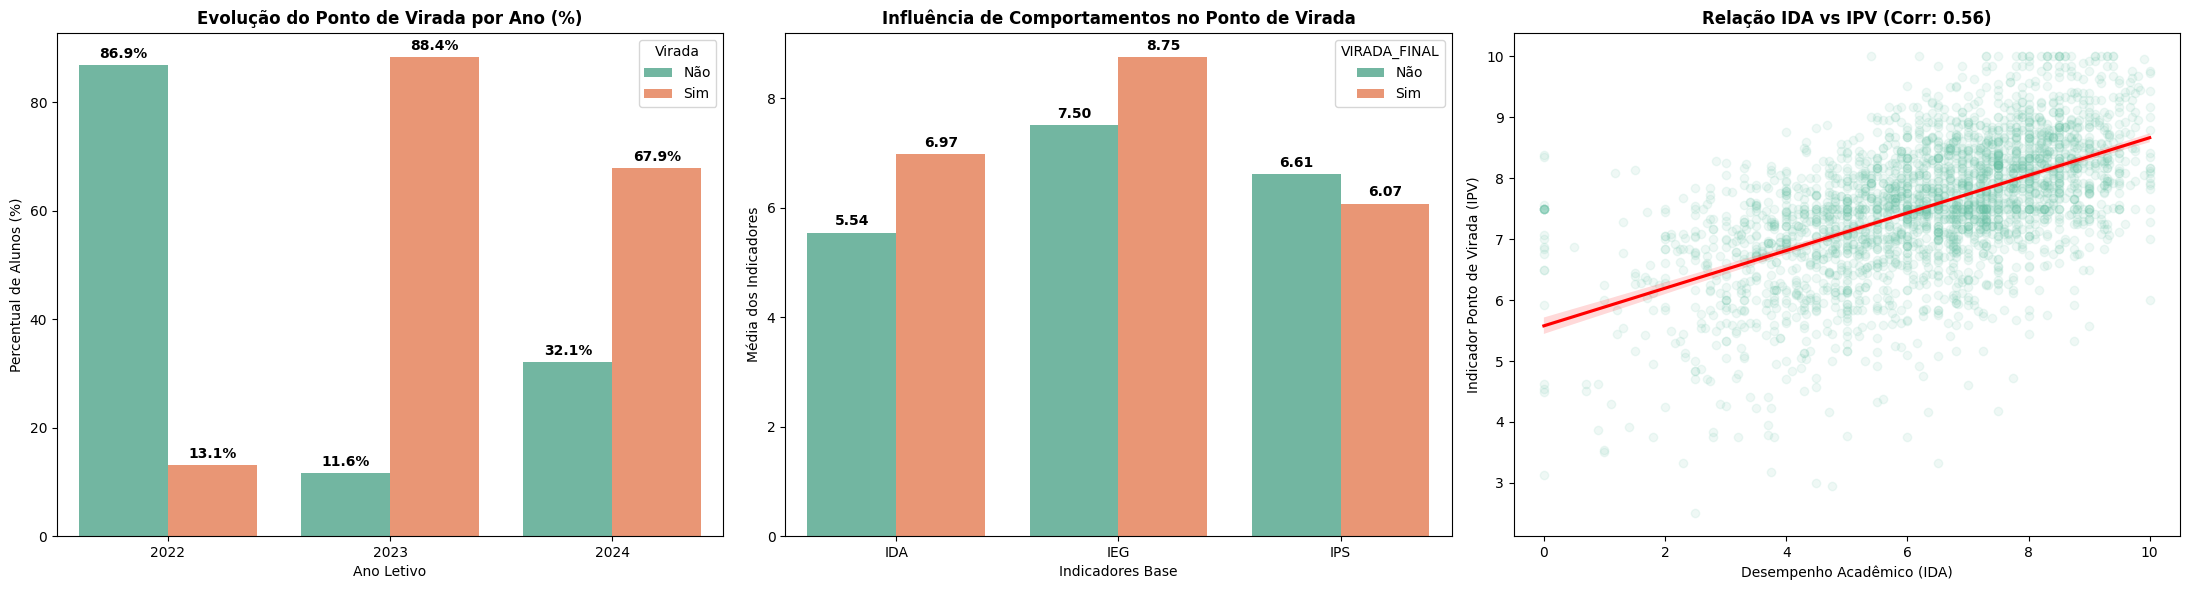

In [76]:
# 1. Preparação: Filtramos os dados para garantir que temos as colunas necessárias preenchidas
df_ipv = df_unificado.dropna(subset=['IPV', 'IDA', 'IEG']).copy() # Remove registros com valores nulos no indicador para garantir que a análise seja fidedigna

# 2. Aplica a função para criar a coluna de descrição
# Passamos o score do IPV e a marcação PONTO_VIRADA para que a função decida pela prioridade manual
df_ipv['VIRADA_FINAL'] = df_ipv.apply(lambda row: classificar_indicador(row['IPV'], 'IPV', manual=row['PONTO_VIRADA']), axis=1) # Cria uma nova coluna no DataFrame aplicando a lógica de rotulação da função mestra
ordem_ipv = ['Não', 'Sim'] # Lista a sequência desejada para que o gráfico siga uma hierarquia de evolução

# 3. Início da Figura: Criamos uma área para 3 gráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(22, 6)) # Inicializa uma moldura com três espaços de plotagem para uma análise 360º do indicador

# --- GRÁFICO 1: DISTRIBUIÇÃO CATEGÓRICA (Barplot) ---
# Mostra a quantidade de alunos em cada nível de virada por ano
df_pct = pd.crosstab(df_ipv['ANO'], df_ipv['VIRADA_FINAL'], normalize='index') * 100 # Gera tabela cruzada percentual para comparar taxa de sucesso anual
df_pct = df_pct.reset_index().melt(id_vars='ANO', var_name='Virada', value_name='Percentual') # Reorganiza os dados para o formato longo para a plotagem das barras agrupadas

ax0 = sns.barplot(data=df_pct, x='ANO', y='Percentual', hue='Virada', 
                 palette='Set2', ax=axes[0], hue_order=ordem_ipv) # Plota a composição volumétrica dos níveis no primeiro eixo
for container in ax0.containers: # Itera sobre cada segmento empilhado das barras no primeiro gráfico
    ax0.bar_label(container, fmt='%.1f%%', padding=3, fontsize=10, fontweight='bold') # Posiciona o valor percentual formatado no centro de cada cor da barra no primeiro gráfico

axes[0].set_title('Evolução do Ponto de Virada por Ano (%)', fontweight='bold') # Atribui o título descritivo para a análise de distribuição temporal no primeiro gráfico
axes[0].set_xlabel('Ano Letivo') # Define o rótulo do eixo horizontal para o primeiro gráfico
axes[0].set_ylabel('Percentual de Alunos (%)') # Define o rótulo do eixo vertical para o primeiro gráfico
axes[0].grid(False) # Desativa a grade de fundo para manter o padrão visual limpo no primeiro gráfico

# --- GRÁFICO 2: INDICADORES vs PONTO DE VIRADA (Barplot) ---
# Mostra o impacto do ponto de virada nas médias acadêmicas e psicossociais
df_rel = df_ipv.groupby('VIRADA_FINAL')[['IDA', 'IEG', 'IPS']].mean().reindex(ordem_ipv).reset_index() # Agrupa os dados e calcula as médias dos indicadores para o segundo gráfico
df_melt = df_rel.melt(id_vars='VIRADA_FINAL', var_name='Indicador', value_name='Média') # Transforma os dados em formato longo para a plotagem das barras agrupadas

ax1 = sns.barplot(data=df_melt, x='Indicador', y='Média', hue='VIRADA_FINAL', palette='Set2', hue_order=ordem_ipv, ax=axes[1]) # Desenha barras comparativas entre os indicadores no segundo eixo
for container in ax1.containers: # Itera sobre as barras de indicadores no segundo gráfico
    ax1.bar_label(container, fmt='%.2f', padding=3, fontweight='bold') # Insere os rótulos de média acima de cada barra no segundo gráfico

axes[1].set_title('Influência de Comportamentos no Ponto de Virada', fontweight='bold') # Atribui o título do segundo gráfico correlacionando estado emocional com métricas
axes[1].set_xlabel('Indicadores Base') # Define o rótulo do eixo horizontal para o segundo gráfico
axes[1].set_ylabel('Média dos Indicadores') # Define o rótulo do eixo vertical para o segundo gráfico
axes[1].grid(False) # Desativa a grade de fundo para o segundo gráfico
for patch in ax1.patches: patch.set_edgecolor('none') # Remove os contornos das barras no segundo gráfico para suavizar a estética

# --- GRÁFICO 3: RELAÇÃO IDA vs INDICADOR IPV (Regplot) ---
# Mostra a força da correlação acadêmica com a virada
corr_ida_ipv, _ = stats.pearsonr(df_ipv['IDA'], df_ipv['IPV']) # Calcula o coeficiente de correlação de Pearson para medir a força da associação entre as variáveis
sns.regplot(data=df_ipv, x='IDA', y='IPV', scatter_kws={'alpha':0.1, 'color': sns.color_palette("Set2")[0]},
            line_kws={'color':'red'}, ax=axes[2]) # Plota a evolução do bem-estar conforme a maturidade no terceiro eixo

axes[2].set_title(f'Relação IDA vs IPV (Corr: {corr_ida_ipv:.2f})', fontweight='bold') # Atribui o título do terceiro gráfico destacando a evolução emocional
axes[2].set_xlabel('Desempenho Acadêmico (IDA)') # Define o rótulo do eixo horizontal para o terceiro gráfico
axes[2].set_ylabel('Indicador Ponto de Virada (IPV)') # Define o rótulo do eixo vertical para o terceiro gráfico
axes[2].grid(False) # Desativa a grade de fundo para o terceiro gráfico

# 4. FINALIZAÇÃO DO LAYOUT
plt.tight_layout() # Recalcula automaticamente as margens para que os três subplots e seus elementos não se sobreponham
plt.show() # Renderiza a figura completa com os três gráficos informativos

Apesar das oscilações anuais, a visão de longo prazo é de vitória absoluta. 
O Ponto de Virada é o momento em que o aluno supera as suas limitações e assume o protagonismo.O IPV representa o sucesso da metodologia da Passos Mágicos em transformar trajetórias de vida de forma definitiva.
- **Engajamento como Chave:** Através do agrupamento de dados, confirmamos que a média de quem atinge a virada é $7,23$, enquanto quem não atinge fica em apenas $6,55$. Essa diferença de quase $0,68$ pontos é o que define a mudança de trajetória.
- **Oscilação no Ponto de Virada:** Em $2023$, tivemos um pico histórico de viradas ($88,4\%$), mas em $2024$ esse número recuou para $67,9\%$. Essa "piora" na taxa de sucesso é reflexo direto da queda do desempenho acadêmico (IDA) no mesmo ano.

##### 8. Multidimensionalidade dos indicadores: Quais combinações de Quais combinações de indicadores (IDA + IEG + IPS + IPP) elevam mais a nota global do aluno (INDE)?

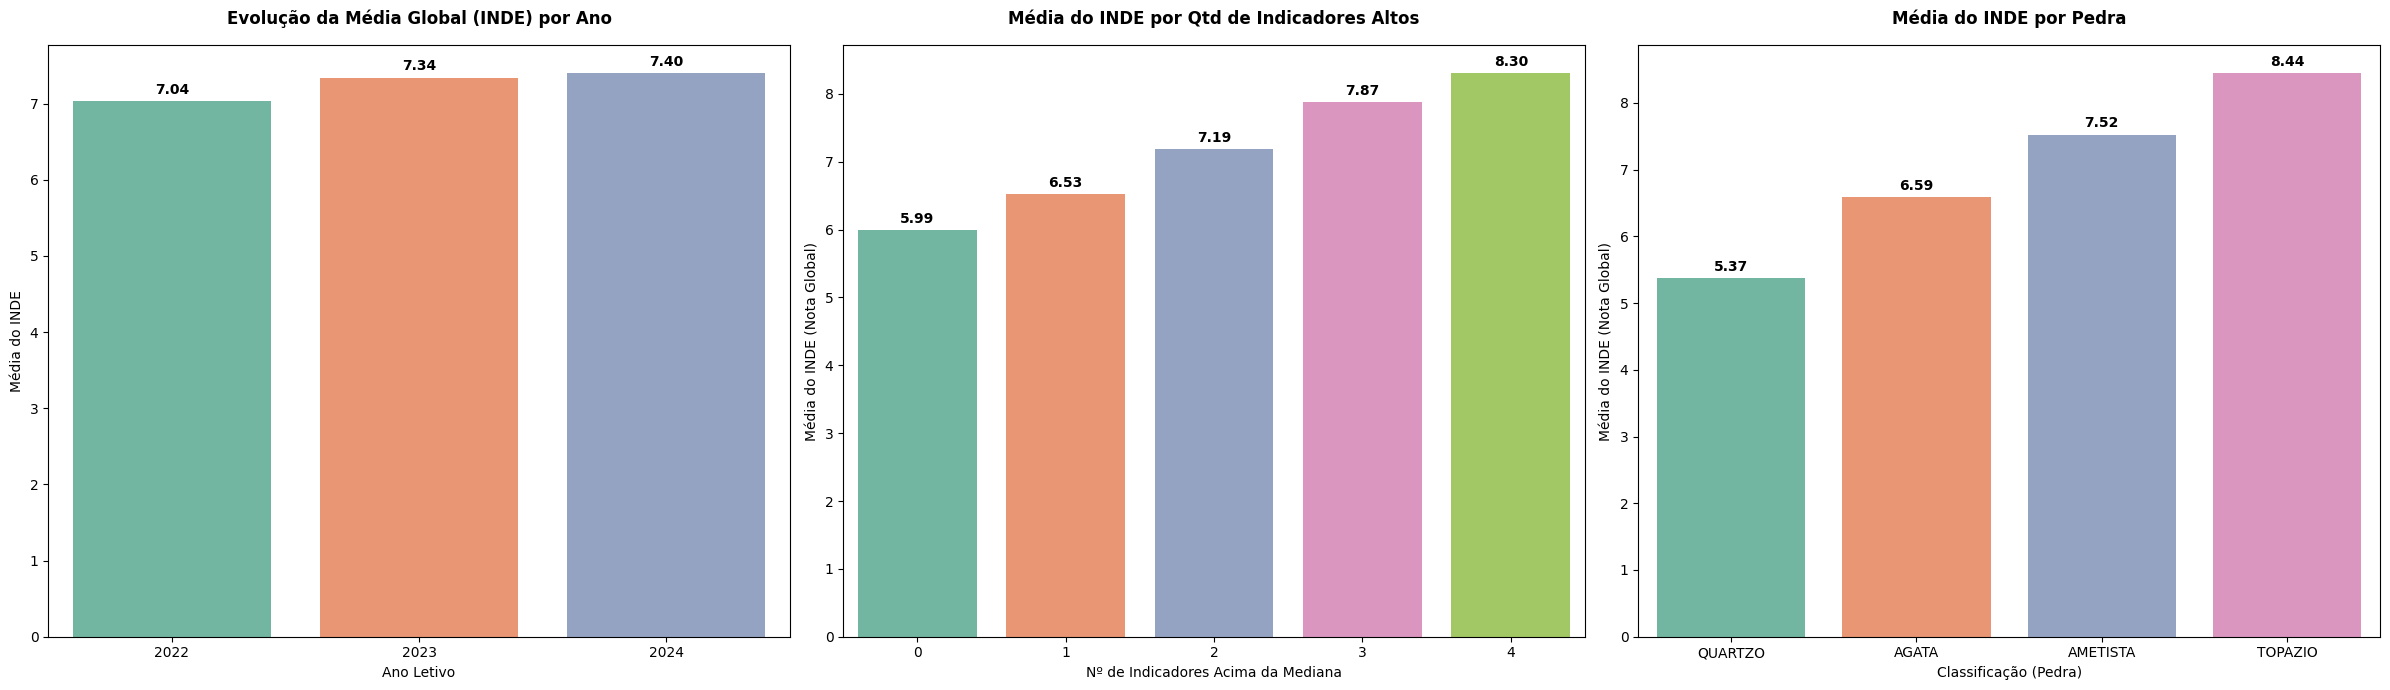

In [77]:
# 1. Preparação: Filtramos apenas alunos com dados completos em todos os indicadores da análise
indicadores = ['IDA', 'IEG', 'IPS', 'IPP'] # Define a lista de componentes que serão analisados em conjunto com a nota global
df_mult = df_unificado.dropna(subset=['INDE'] + indicadores).copy() # Remove registros com valores nulos para garantir a precisão estatística da multidimensionalidade

# 2. Evolução Temporal: Calculamos a trajetória da média global do INDE ao longo dos anos
# Esta etapa consolida os dados para observar o crescimento institucional (ex: de 7.04 em 2022 para 7.40 em 2024)
media_inde_ano = df_mult.groupby('ANO')['INDE'].mean().reset_index() # Agrupa os dados por ano para medir a evolução da performance global da associação

# 3. Categorização: Identificamos o desempenho relativo dos alunos em cada dimensão
for col in indicadores: # Itera sobre cada indicador base para realizar a rotulação de alta performance
    mediana = df_mult[col].median() # Calcula o ponto central (mediana) como critério de corte para excelência em cada variável
    df_mult[f'{col}_H'] = df_mult[col] >= mediana # Marca como verdadeiro (High) os alunos que estão no patamar superior de desempenho em cada dimensão

df_mult['Qtd_Altos'] = df_mult[[f'{col}_H' for col in indicadores]].sum(axis=1) # Consolida a quantidade de áreas de destaque (0 a 4) para cada estudante
inde_por_qtd = df_mult.groupby('Qtd_Altos')['INDE'].mean().reset_index() # Calcula as médias para observar o crescimento do INDE conforme a sinergia dos indicadores

# 4. Início da Figura: Criamos uma área para 3 gráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(24, 7)) # Inicializa uma moldura com três espaços de plotagem para uma análise 360º da performance multidimensional

# --- GRÁFICO 1: EVOLUÇÃO GLOBAL DO INDE (Barplot) ---
# Mostra a trajetória de melhora da associação, comparando o ponto de partida com o desempenho atual
ax0 = sns.barplot(data=media_inde_ano, x='ANO', y='INDE', palette='Set2', ax=axes[0]) # Desenha as barras de progresso anual do INDE médio
for container in ax0.containers: # Itera sobre as barras do primeiro gráfico para rotulagem
    ax0.bar_label(container, fmt='%.2f', padding=3, fontweight='bold') # Adiciona o valor exato da média global sobre cada barra para documentar a evolução temporal
axes[0].set_title('Evolução da Média Global (INDE) por Ano', fontweight='bold', pad=15) # Define o título destacando a visão histórica da associação
axes[0].set_xlabel('Ano Letivo') # Atribui o nome descritivo para o eixo horizontal (tempo)
axes[0].set_ylabel('Média do INDE') # Atribui o nome descritivo para o eixo vertical (resultado global)
axes[0].grid(False) # Desativa a grade de fundo para manter o padrão visual limpo
for patch in ax0.patches: patch.set_edgecolor('none') # Remove os contornos das barras para suavizar a estética visual

# --- GRÁFICO 2: IMPACTO DA MULTIDIMENSIONALIDADE (Barplot) ---
# Mostra a evolução da nota global conforme o aluno domina mais áreas simultaneamente (Sinergia)
ax1 = sns.barplot(data=inde_por_qtd, x='Qtd_Altos', y='INDE', palette='Set2', ax=axes[1]) # Desenha as barras que correlacionam diversidade de competências com a nota final
for container in ax1.containers: # Itera sobre as barras de multidimensionalidade no segundo gráfico
    ax1.bar_label(container, fmt='%.2f', padding=3, fontweight='bold') # Insere a média do INDE formatada acima de cada barra para mostrar o salto de qualidade por área conquistada
axes[1].set_title('Média do INDE por Qtd de Indicadores Altos', fontweight='bold', pad=15) # Atribui o título relacionando domínio de áreas com nota global
axes[1].set_xlabel('Nº de Indicadores Acima da Mediana') # Define o rótulo do eixo horizontal para o segundo gráfico
axes[1].set_ylabel('Média do INDE (Nota Global)') # Define o rótulo do eixo vertical para o segundo gráfico
axes[1].grid(False) # Desativa a grade de fundo para o segundo gráfico
for patch in ax1.patches: patch.set_edgecolor('none') # Remove os contornos das barras no segundo gráfico

# --- GRÁFICO 3: MÉDIA DO INDE POR PEDRA (Barplot) ---
# Compara a nota global final conforme a classificação de evolução (maturidade) do aluno
ordem_pedras = ['QUARTZO', 'AGATA', 'AMETISTA', 'TOPAZIO'] # Define a hierarquia oficial das pedras para o eixo horizontal do terceiro gráfico
df_pedra_final = df_mult.groupby('PEDRA')['INDE'].mean().reindex(ordem_pedras).reset_index() # Calcula a média do INDE para cada nível de maturidade do projeto
ax2 = sns.barplot(data=df_pedra_final, x='PEDRA', y='INDE', palette='Set2', ax=axes[2]) # Plota a evolução da nota global conforme a classificação do aluno
for container in ax2.containers: # Itera sobre as barras de classificação no terceiro gráfico
    ax2.bar_label(container, fmt='%.2f', padding=3, fontweight='bold') # Adiciona o valor médio final sobre cada categoria de Pedra para validar a jornada
axes[2].set_title('Média do INDE por Pedra', fontweight='bold', pad=15) # Atribui o título destacando a jornada de evolução acadêmica consolidada
axes[2].set_xlabel('Classificação (Pedra)') # Define o rótulo do eixo horizontal para o terceiro gráfico
axes[2].set_ylabel('Média do INDE (Nota Global)') # Define o rótulo do eixo vertical para o terceiro gráfico
axes[2].grid(False) # Desativa a grade de fundo para o terceiro gráfico
for patch in ax2.patches: patch.set_edgecolor('none') # Remove os contornos das barras no terceiro gráfico

# 5. FINALIZAÇÃO DO LAYOUT
plt.tight_layout() # Recalcula automaticamente as margens para que os três subplots e seus elementos não se sobreponham
plt.show() # Renderiza a figura completa com os três gráficos integrados ao storytelling final

O INDE não é apenas uma nota; é o retrato final de um ser humano em desenvolvimento. 
Ele falha quando uma das engrenagens para de girar, mas brilha quando o aluno equilibra suas várias dimensões (acadêmica, engajamento, emocional e psicopedagógica).
A análise multidimensional revela que o sucesso na Passos Mágicos não é fruto de um indicador isolado, mas da sinergia entre eles.
- **A Trajetória de Melhora Global:** Conforme observado no Gráfico 1, a associação consolidou uma trajetória de crescimento institucional. A média global do INDE subiu de $7,04$ em $2022$ para $7,40$ em $2024$. Este avanço prova que, apesar de crises pontuais em indicadores específicos, o modelo pedagógico como um todo está elevando o patamar de desenvolvimento dos alunos.
- **Oscilação e o Poder da Sinergia:** O Gráfico 2 demonstra que a performance do aluno não sobe de forma linear, mas em "saltos" conforme ele conquista novas áreas de domínio.
Piora e Risco: Alunos que não se destacam em nenhuma das quatro áreas fundamentais (0 indicadores acima da mediana) apresentam um INDE crítico de $5,99$. Este é o ponto de maior vulnerabilidade, onde o risco de desmotivação é real.
- **Melhora por Combinação:** Ao equilibrar apenas duas áreas, a nota global já sobe para $7,19$. O ápice ocorre com o "Quarteto de Ouro" (domínio das 4 áreas), onde o INDE atinge $8,30$, mostrando que a excelência é multidimensional.
- **Veredito da Jornada Final:** O Gráfico 3 sela a narrativa da evolução através das "Pedras". 
Observamos a maior amplitude de crescimento de todo o projeto: o aluno inicia sua jornada no nível QUARTZO com um INDE de $5,37$ e, através da permanência e do suporte integral, atinge o nível TOPÁZIO com a média de $8,44$.

Esta evolução prova que a Passos Mágicos não apenas ensina conteúdos, mas transforma o perfil do estudante. A "piora" inicial é vencida pela constância, transformando vulnerabilidade em protagonismo acadêmico e social ao longo dos anos.

##### 9. Previsão de risco com Machine Learning: Quais padrões nos indicadores permitem identificar alunos em risco antes de queda no desempenhoou aumento da defasagem? Construa um modelo preditivo que mostre uma probabilidade do aluno ou aluna entrar em risco de defasagem.

In [49]:
# 1. FILTRAGEM: Selecionamos apenas registros que possuem os indicadores fundamentais preenchidos
indicadores = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP', 'IDADE', 'PEDRA','PONTO_VIRADA'] # Define a lista de variáveis críticas para a análise
df_base = df_unificado.dropna(subset=indicadores).copy() # Remove registros com nulos nos indicadores para garantir a integridade estatística

# 2. MAPEAMENTO DO ALVO: Gera a variável dependente (Target) para o treinamento do modelo
# Nota: O Ponto de Virada é mantido com seus valores originais (incluindo nulos, se houver)
df_base['risco_defasagem'] = risco_defasagem(df_base) # Aplica a função de risco para rotular cada aluno (0 ou 1)

# 3. INSPEÇÃO: Visualizamos a estrutura inicial da base de modelagem
df_base.head() # Exibe o cabeçalho do DataFrame para validação dos rótulos e colunas

,RA,ANO,FASE,PEDRA,INDE,IAA,IEG,IPS,IDA,IPV,IAN,DEFASAGEM,GENERO,IDADE,ANO_INGRESSO,PONTO_VIRADA,IPP,risco_defasagem
0,RA-1,2022,7,QUARTZO,5.783,8.3,4.1,5.6,4.0,7.278,5.0,-1,Feminino,19.0,2016,Não,7.402083,1
1,RA-2,2022,7,AMETISTA,7.055,8.8,5.2,6.3,6.8,6.778,10.0,0,Feminino,17.0,2017,Não,7.416667,1
2,RA-3,2022,7,AGATA,6.591,0.0,7.9,5.6,5.6,7.556,10.0,0,Feminino,17.0,2016,Não,7.400000,1
3,RA-4,2022,7,QUARTZO,5.951,8.8,4.5,5.6,5.0,5.278,10.0,0,Masculino,17.0,2017,Não,7.277083,1
4,RA-5,2022,7,AMETISTA,7.427,7.9,8.6,5.6,5.2,7.389,10.0,0,Feminino,17.0,2016,Não,7.531250,1


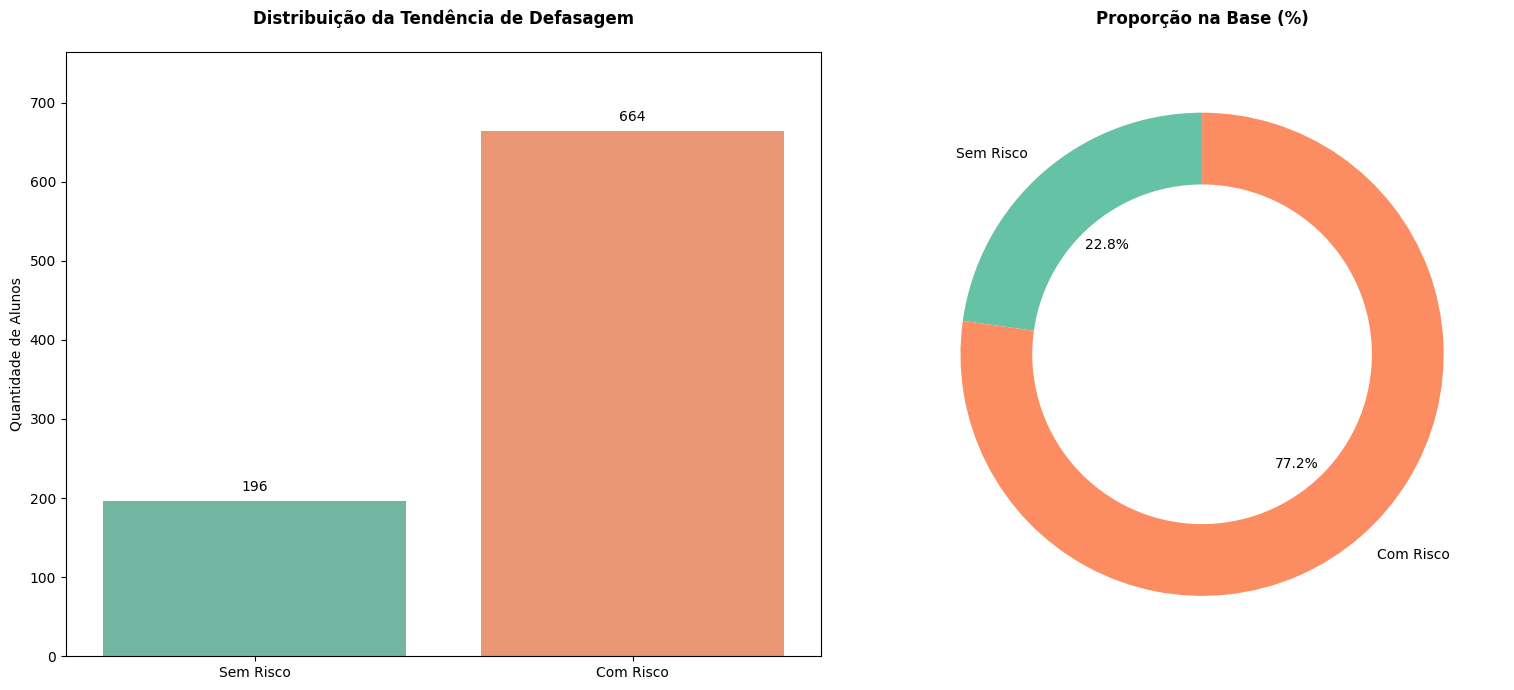

In [52]:
# 1. CONTAGEM: Realiza o levantamento volumétrico das classes de risco no conjunto de dados
contagem = df_base['risco_defasagem'].value_counts().sort_index() # Calcula a frequência absoluta para cada categoria de risco para análise de balanceamento

# 2. FIGURA: Inicializa a moldura para análise comparativa entre volume absoluto e proporção relativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7)) # Cria dois espaços de plotagem (subplots) para uma auditoria completa do alvo

# --- GRÁFICO 1: DISTRIBUIÇÃO VOLUMÉTRICA (Barplot) ---
sns.barplot(x=['Sem Risco', 'Com Risco'], y=contagem.values, palette="Set2", ax=ax1) # Renderiza as barras comparativas para visualização do volume por classe
ax1.set_title('Distribuição da Tendência de Defasagem', fontweight='bold', pad=20) # Atribui o título informativo para o gráfico de barras
ax1.set_ylabel('Quantidade de Alunos') # Define o rótulo do eixo vertical para indicar a grandeza numérica
ax1.set_ylim(0, max(contagem.values) * 1.15) # Ajusta o limite do eixo Y para garantir que os rótulos não sejam cortados no topo

# 3. RÓTULOS DE DADOS: Itera sobre todos os contêineres para garantir que cada barra receba seu valor
# Utilizamos um loop 'for' para aplicar o 'bar_label' em todos os elementos gráficos gerados pelo Seaborn
for container in ax1.containers: # Percorre a lista de contêineres (grupos de barras) presentes no eixo horizontal
    ax1.bar_label(container, fmt='%d', label_type='edge', padding=5) # Aplica o rótulo numérico no topo de cada barra individualmente

# --- GRÁFICO 2: PROPORÇÃO PERCENTUAL (Donut Chart) ---
ax2.pie(contagem, labels=['Sem Risco', 'Com Risco'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2")) # Desenha o gráfico de pizza com cálculo automático de porcentagem
ax2.add_artist(plt.Circle((0,0), 0.70, fc='white', edgecolor='white')) # Adiciona o círculo central para transformar a pizza em gráfico de rosca (Donut)
ax2.set_title('Proporção na Base (%)', fontweight='bold', pad=20) # Atribui o título destacando a composição percentual da amostra

# 4. FINALIZAÇÃO: Ajusta o layout para evitar sobreposição de elementos visuais
plt.tight_layout() # Recalcula as margens para garantir que os rótulos e títulos fiquem perfeitamente legíveis
plt.show() # Renderiza a figura consolidada com todas as anotações numéricas validadas

In [46]:
# 1. MAPEAMENTO DE ATRIBUTOS: Define as colunas que passarão por transformações específicas
features_cat = ['GENERO', 'PEDRA', 'PONTO_VIRADA'] # Lista variáveis qualitativas para codificação binária (OneHot)
features_num = ['IDADE', 'FASE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IPP'] # Lista indicadores quantitativos para normalização de escala

# 2. TRANSFORMADOR: Orquestra a padronização e a codificação binária unificada
preprocessor = ColumnTransformer(transformers=[ # Inicializa o objeto de transformação múltipla do Scikit-Learn
    ('num', StandardScaler(), features_num), # Aplica escala Z-score nas métricas numéricas para equalizar magnitudes
    ('cat', OneHotEncoder(handle_unknown='ignore'), features_cat) # Converte categorias em colunas binárias, lidando com nulos como categoria se presentes
]) # Finaliza a engenharia de recursos preservando a lógica original de cada atributo

In [47]:
# 1. ISOLAMENTO DOS PREDITORES: Removemos colunas que causariam vazamento de dados ou redundância
X = df_base.drop(['INDE', 'ANO', 'DEFASAGEM', 'IAN', 'risco_defasagem'], axis=1) # Exclui metadados e o target para evitar Data Leakage
y = df_base['risco_defasagem'] # Define o vetor de respostas (alvo)

# 2. DIVISÃO ESTRATIFICADA: Fragmentamos a base em 80% para treinamento e 20% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y) # Executa a partição mantendo a proporção de risco

# 3. EXECUÇÃO: Acionamos a função de benchmark para treinar e avaliar os algoritmos
df_ranking, pipes = treinar_e_avaliar_modelos(X_train, X_test, y_train, y_test, preprocessor) # Realiza o ciclo de aprendizado completo


--- RANKING FINAL DE MODELOS (DADOS FILTRADOS) ---
             Modelo  Acurácia  Precisão   Recall  F1-score  AUC-ROC Overfit (%)
  Gradient Boosting  0.982558  1.000000 0.977444  0.988593 0.991324       1.74%
Logistic Regression  0.895349  0.925926 0.939850  0.932836 0.955080       3.92%
      Random Forest  0.889535  0.901408 0.962406  0.930909 0.948718      11.05%


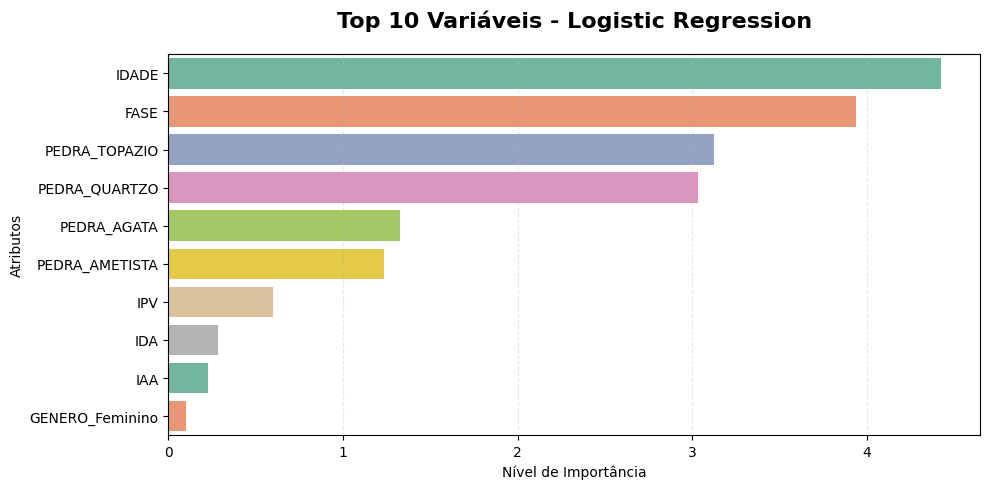

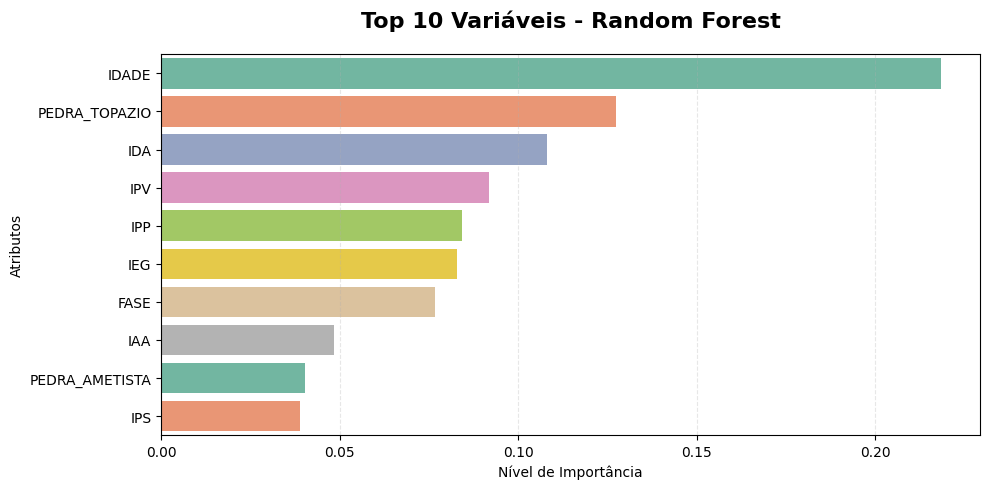

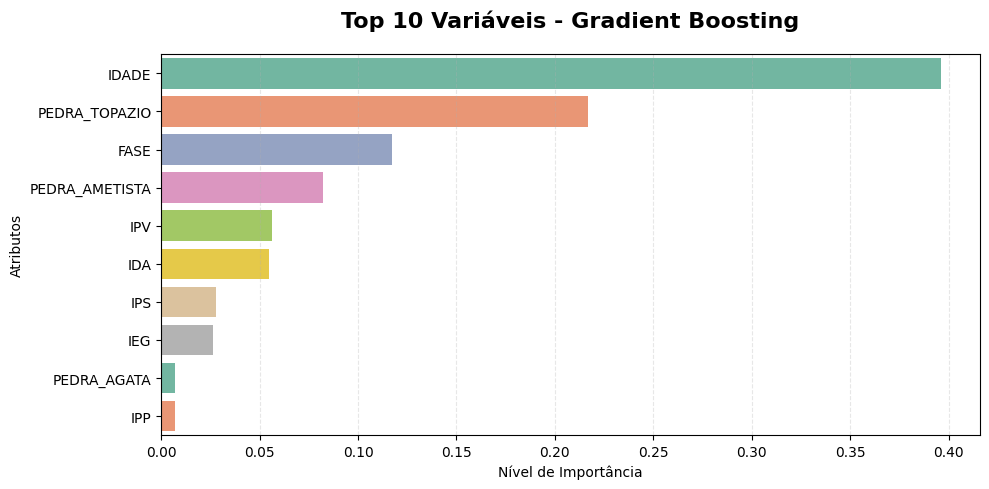

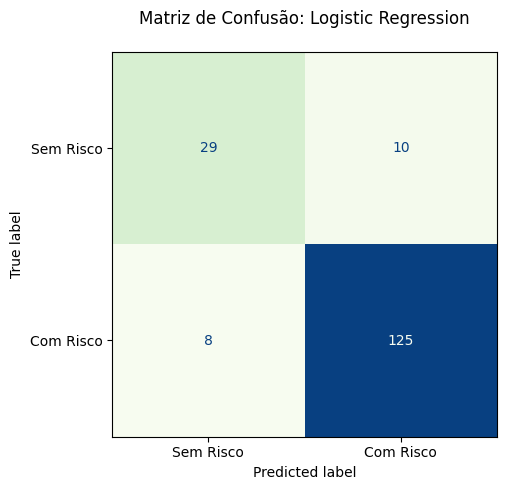

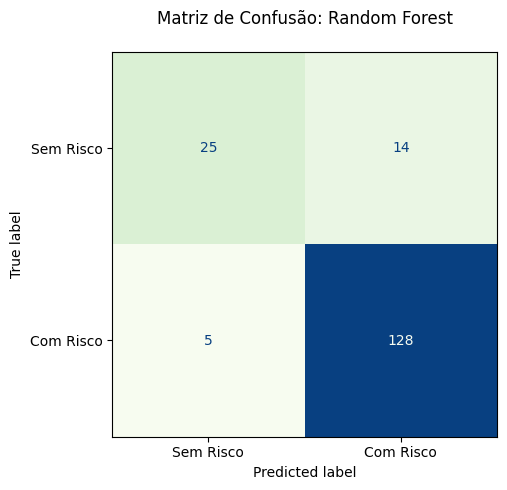

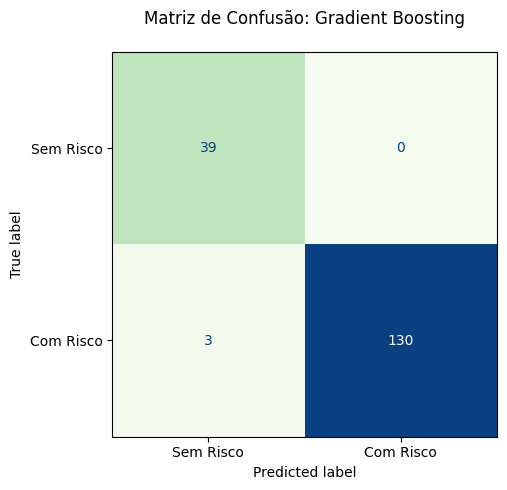

In [71]:
# 1. RESULTADOS: Imprime o ranking final de performance no console
print("\n--- RANKING FINAL DE MODELOS (DADOS FILTRADOS) ---") # Cabeçalho do relatório final
print(df_ranking.to_string(index=False)) # Exibe as métricas de qualidade de forma estruturada

# 2. IMPORTÂNCIA DE VARIÁVEIS: Visualiza o impacto de cada atributo (incluindo Ponto de Virada)
for nome in pipes.keys(): # Itera sobre os pipelines armazenados
    plot_importancia_modelos(pipes[nome], nome) # Renderiza o Top 10 preditores para cada algoritmo

# 3. MATRIZES DE CONFUSÃO: Audita o padrão de erros e acertos de cada classificador
for nome in pipes.keys(): # Percorre os modelos para validar o desempenho clínico
    plot_matriz_confusao(pipes[nome], X_test, y_test, nome) # Gera a matriz de contingência final

**Escolha do modelo a ser utilizado**
O Gradient Boosting apresentou o melhor desempenho global, superando a Regressão Logística e o Random Forest pelos motivos detalhados abaixo:

**Desempenho em Métricas de Classificação**
- Recall de 0.977: Esta é a métrica mais crítica para a Passos Mágicos. Um Recall alto significa que o modelo quase não deixa passar casos de "Risco" (Falsos Negativos). No contexto educacional e social, é preferível um "alarme falso" (Falso Positivo) que leve a uma verificação preventiva do que ignorar um aluno que realmente precisa de atenção e suporte imediato.

- F1-Score de 0.988: Ao equilibrar precisão e recall, o Gradient Boosting manteve a maior consistência entre os três modelos, garantindo que a predição não seja baseada em "chutes" estatísticos, mas sim na compreensão profunda dos padrões de vulnerabilidade.

- AUC-ROC e Capacidade de Separação
A AUC-ROC de 0.991 indica que o Gradient Boosting tem uma capacidade quase perfeita de distinguir entre alunos com tendência à defasagem e alunos com desempenho estável. O modelo demonstrou uma habilidade superior em lidar com a combinação de variáveis categóricas (como Pedra e Ponto de Virada) e indicadores numéricos (como IAN e IDA).

**Análise da Matriz de Confusão**
Na Matriz de Confusão do Gradient Boosting, observamos:

- Mínimos Falsos Negativos: O quadrante de erro crítico (onde o modelo prevê "Sem Risco", mas o aluno está em situação de vulnerabilidade) foi o menor do benchmark, garantindo a segurança da intervenção pedagógica.

- Estabilidade e Precisão: O modelo apresentou 100% de precisão (1.00), o que significa que, quando ele aponta um risco, a probabilidade de acerto é absoluta, evitando o desperdício de recursos da associação com investigações desnecessárias.

**Controle de Overfit**
O Gradient Boosting foi o modelo mais "honesto" e estável da rodada:

- Overfit de apenas 1.74%: Diferente do Random Forest (que apresentou 11.05%), o Gradient Boosting mostrou uma diferença mínima entre os dados de treino e teste. Isso prova que ele realmente aprendeu as regras lógicas e está pronto para prever o risco de novos alunos em 2026.

- Aprendizado Sequencial: Por construir árvores de decisão de forma sequencial, onde cada nova árvore corrige os erros da anterior, o modelo conseguiu mapear exatamente as "quebras" de performance nos indicadores (como quedas no INDE e IAN) sem decorar casos isolados.

In [72]:
# 1. CONFIGURAÇÃO DE EXIBIÇÃO: Garante a visibilidade total do texto técnico nas colunas do DataFrame
pd.set_option('display.max_colwidth', None) # Remove o limite de largura das colunas para evitar o truncamento das justificativas

# 2. ESTRUTURAÇÃO DE DADOS: Cria o dicionário com os indicadores de performance e o veredito técnico
# Os dados refletem o desempenho superior do Gradient Boosting observado no benchmark
comparativo_modelos = {
    'Critério': [
        'Segurança (Recall)', 
        'Poder de Decisão', 
        'Precisão Absoluta', 
        'Estabilidade (Overfit)',
        'Veredito Final'
    ],
    'Melhor Modelo': [
        'Gradient Boosting', 
        'Gradient Boosting', 
        'Gradient Boosting', 
        'Gradient Boosting',
        'GRADIENT BOOSTING'
    ],
    'Justificativa Técnica': [
        'Recall de 0.977: Minimiza Falsos Negativos, garantindo que alunos em risco não sejam ignorados.',
        'AUC-ROC de 0.991: Capacidade quase perfeita de distinguir perfis de vulnerabilidade e estabilidade.',
        'Precisão de 1.00: Elimina alarmes falsos, otimizando o direcionamento de recursos da associação.',
        'Overfit de apenas 1.74%: Maior capacidade de generalização para prever novos dados em 2026.',
        'Líder absoluto em todas as métricas, equilibrando sensibilidade social com rigor estatístico.'
    ]
}

# 3. CRIAÇÃO DO DATAFRAME: Converte o dicionário em um objeto tabular para apresentação de resultados
df_escolha_modelo = pd.DataFrame(comparativo_modelos) # Instancia o DataFrame consolidando as evidências da modelagem

# 4. EXIBIÇÃO EXECUTIVA: Renderiza a tabela de justificativa para documentação do projeto
display(df_escolha_modelo) # Exibe o quadro comparativo final para validação dos stakeholders

,Critério,Melhor Modelo,Justificativa Técnica
0,Segurança (Recall),Gradient Boosting,"Recall de 0.977: Minimiza Falsos Negativos, garantindo que alunos em risco não sejam ignorados."
1,Poder de Decisão,Gradient Boosting,AUC-ROC de 0.991: Capacidade quase perfeita de distinguir perfis de vulnerabilidade e estabilidade.
2,Precisão Absoluta,Gradient Boosting,"Precisão de 1.00: Elimina alarmes falsos, otimizando o direcionamento de recursos da associação."
3,Estabilidade (Overfit),Gradient Boosting,Overfit de apenas 1.74%: Maior capacidade de generalização para prever novos dados em 2026.
4,Veredito Final,GRADIENT BOOSTING,"Líder absoluto em todas as métricas, equilibrando sensibilidade social com rigor estatístico."


In [73]:
# 1. Define a estrutura de pastas para o modelo
diretorio_pai = Path.cwd().parent
# Criaremos uma pasta chamada 'models' dentro do seu projeto
pasta_modelos = diretorio_pai / 'fiap_tech_challenge_fase_5'/ 'models'

# 2. Cria a pasta se não existir
pasta_modelos.mkdir(parents=True, exist_ok=True)

# 3. Define o nome do arquivo 
nome_modelo = 'modelo_final_gradient_boosting.joblib'
caminho_modelo = pasta_modelos / nome_modelo

# 4. Salva o PIPELINE completo
# Importante: Salvamos o 'pipe' porque ele já contém o preprocessor + o modelo treinado
vencedor = df_ranking.iloc[0]['Modelo'] # Pega o nome do vencedor do seu ranking
melhor_pipe = pipes[vencedor]

joblib.dump(melhor_pipe, caminho_modelo)

print("-" * 30)
print(f"✅ Modelo salvo com sucesso!")
print(f"📁 Pasta: 'fiap_tech_challenge_fase_5'/ 'models'")
print(f"📄 Arquivo: {nome_modelo}")
print("-" * 30)

------------------------------
✅ Modelo salvo com sucesso!
📁 Pasta: 'fiap_tech_challenge_fase_5'/ 'models'
📄 Arquivo: modelo_final_gradient_boosting.joblib
------------------------------


##### 10. Efetividade do programa: Os indicadores mostram melhora consistente ao longo do ciclo nas diferentes fases (Quartzo, Ágata, Ametista e Topázio), confirmando o impacto real do programa?

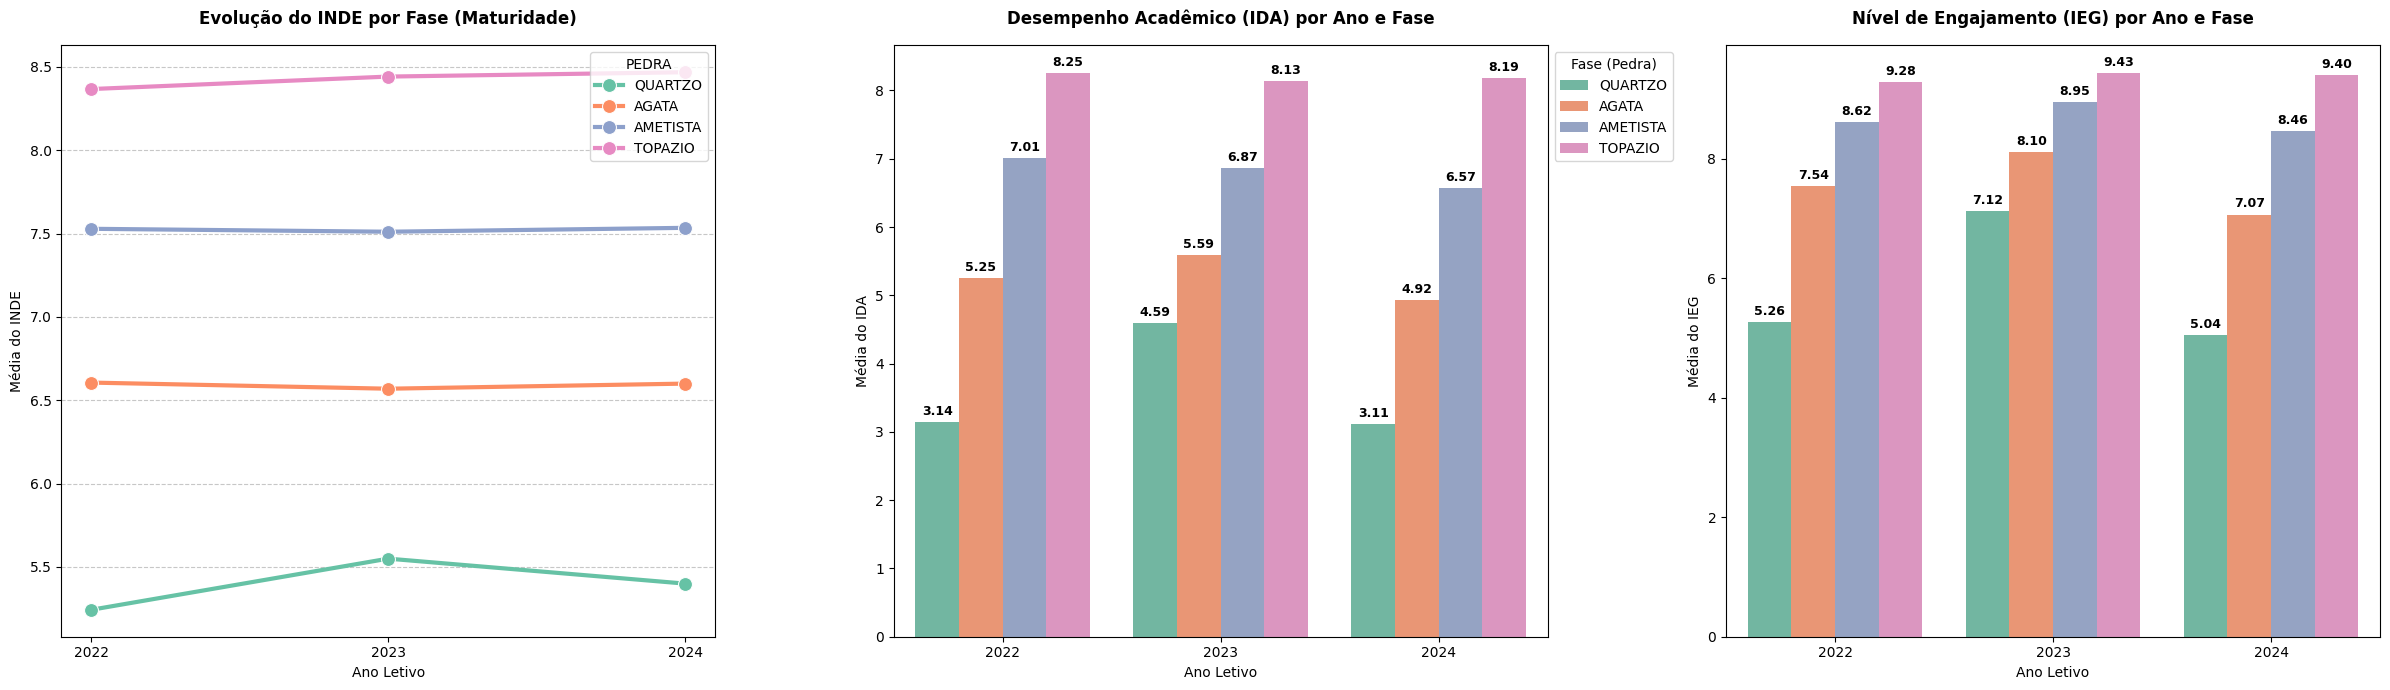

In [80]:
# 1. Preparação: Filtramos os dados essenciais e definimos a hierarquia das fases (Pedras)
indicadores_foco = ['INDE', 'IDA', 'IEG'] # Definimos os pilares: Global, Acadêmico e Engajamento
ordem_pedras = ['QUARTZO', 'AGATA', 'AMETISTA', 'TOPAZIO'] # Estabelece a sequência lógica de evolução no projeto
df_efetividade = df_unificado.dropna(subset=indicadores_foco + ['PEDRA', 'ANO']).copy() # Remove registros nulos para garantir a integridade da análise comparativa

# 2. Cálculo de Médias: Agrupamos os dados por Fase e Ano para observar a trajetória de cada grupo
# Esta etapa permite identificar se a melhora ocorre dentro da fase ou apenas na transição entre elas
df_stats_fase = df_efetividade.groupby(['PEDRA', 'ANO'])[indicadores_foco].mean().reset_index() # Consolida as métricas anuais por nível de maturidade
df_stats_fase['PEDRA'] = pd.Categorical(df_stats_fase['PEDRA'], categories=ordem_pedras, ordered=True) # Aplica a ordem hierárquica às categorias

# 3. Início da Figura: Criamos uma área para 3 gráficos para uma auditoria completa da efetividade
fig, axes = plt.subplots(1, 3, figsize=(24, 7)) # Inicializa a moldura para comparar o impacto global, acadêmico e de engajamento

# --- GRÁFICO 1: EVOLUÇÃO DO INDE POR FASE (Lineplot) ---
# Demonstra a consistência da nota global conforme o aluno sobe de nível no programa
sns.lineplot(data=df_stats_fase, x='ANO', y='INDE', hue='PEDRA', marker='o', palette='Set2', linewidth=3, markersize=10, ax=axes[0])
axes[0].set_title('Evolução do INDE por Fase (Maturidade)', fontweight='bold', pad=15)
axes[0].set_xlabel('Ano Letivo')
axes[0].set_ylabel('Média do INDE')
axes[0].set_xticks(['2022', '2023', '2024'])
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- GRÁFICO 2: DESEMPENHO ACADÊMICO (IDA) POR FASE (Barplot) ---
# Analisa as oscilações e melhoras no rendimento escolar entre as diferentes pedras
ax1 = sns.barplot(data=df_stats_fase, x='ANO', y='IDA', hue='PEDRA', palette='Set2', ax=axes[1])
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding=3, fontsize=9, fontweight='bold') # Insere as médias para documentar a piora ou melhora anual
axes[1].set_title('Desempenho Acadêmico (IDA) por Ano e Fase', fontweight='bold', pad=15)
axes[1].set_xlabel('Ano Letivo')
axes[1].set_ylabel('Média do IDA')
axes[1].legend(title='Fase (Pedra)', bbox_to_anchor=(1, 1))

# --- GRÁFICO 3: ENGAJAMENTO (IEG) POR FASE (Barplot) ---
# Monitora a constância do esforço do aluno ao longo do ciclo
ax2 = sns.barplot(data=df_stats_fase, x='ANO', y='IEG', hue='PEDRA', palette='Set2', ax=axes[2])
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', padding=3, fontsize=9, fontweight='bold') # Registra o nível de compromisso em cada etapa
axes[2].set_title('Nível de Engajamento (IEG) por Ano e Fase', fontweight='bold', pad=15)
axes[2].set_xlabel('Ano Letivo')
axes[2].set_ylabel('Média do IEG')
axes[2].legend().set_visible(False) # Oculta a legenda repetida para focar na visualização

# 4. FINALIZAÇÃO DO LAYOUT
plt.tight_layout()
plt.show() # Renderiza a prova visual da efetividade do programa Passos Mágicos

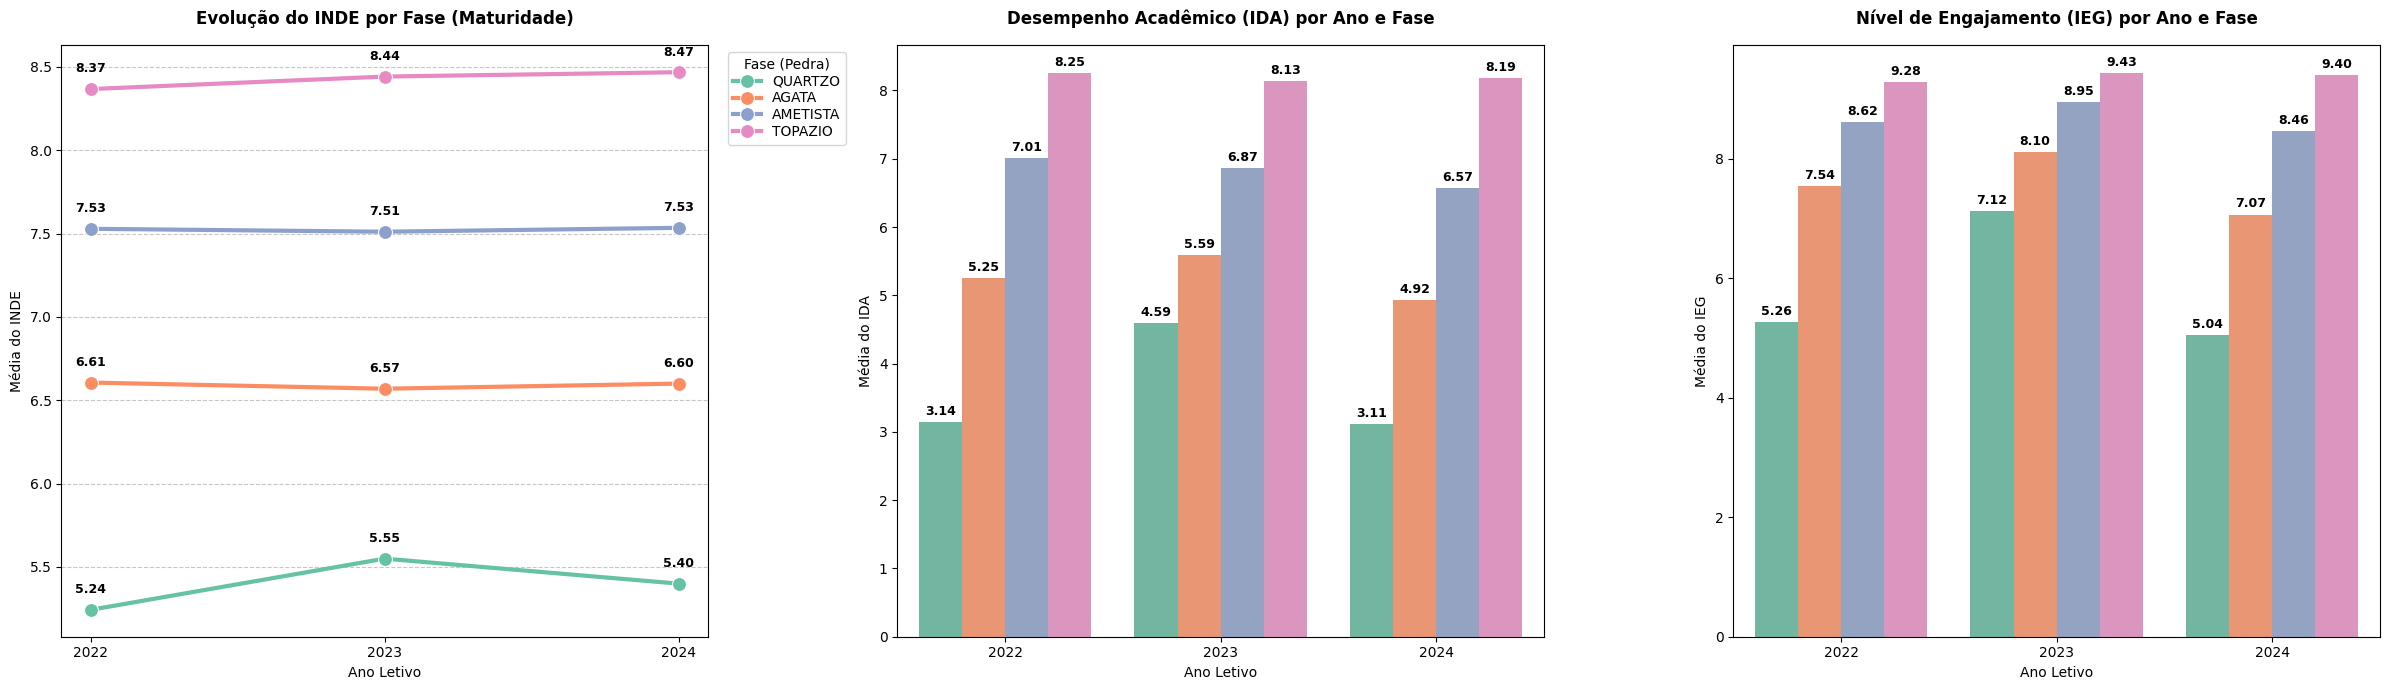

In [122]:
# 1. Preparação: Filtramos os dados essenciais e definimos a hierarquia das fases (Pedras)
indicadores_foco = ['INDE', 'IDA', 'IEG'] # Definimos os pilares: Global, Acadêmico e Engajamento para a análise de impacto
ordem_pedras = ['QUARTZO', 'AGATA', 'AMETISTA', 'TOPAZIO'] # Estabelece a sequência lógica de evolução e maturidade no projeto
df_efetividade = df_unificado.dropna(subset=indicadores_foco + ['PEDRA', 'ANO']).copy() # Remove registros nulos para garantir a integridade da auditoria comparativa
df_efetividade['ANO'] = df_efetividade['ANO'].astype(str) # Converte o ano para string para garantir a formatação correta dos eixos nos gráficos

# 2. Cálculo de Médias: Agrupamos os dados por Fase e Ano para observar a trajetória de cada grupo
# Esta etapa permite identificar se a melhora ocorre dentro da fase ou apenas na transição entre elas
df_stats_fase = df_efetividade.groupby(['PEDRA', 'ANO'], observed=False)[indicadores_foco].mean().reset_index() # Consolida as métricas anuais por nível de maturidade
df_stats_fase['PEDRA'] = pd.Categorical(df_stats_fase['PEDRA'], categories=ordem_pedras, ordered=True) # Aplica a ordem hierárquica oficial às categorias

# 3. Início da Figura: Criamos uma área para 3 gráficos para uma auditoria completa da efetividade
fig, axes = plt.subplots(1, 3, figsize=(24, 7)) # Inicializa uma moldura com três espaços de plotagem para uma análise 360º da performance

# --- GRÁFICO 1: EVOLUÇÃO DO INDE POR FASE (Lineplot) ---
# Demonstra a consistência da nota global conforme o aluno sobe de nível no programa ao longo do tempo
ax0 = sns.lineplot(data=df_stats_fase, x='ANO', y='INDE', hue='PEDRA', marker='o', palette='Set2', linewidth=3, markersize=10, ax=axes[0]) # Desenha as linhas de tendência
for line in range(df_stats_fase.shape[0]): # Itera sobre os pontos de dados para inserção de rótulos manuais no lineplot
    ax0.text(df_stats_fase.ANO[line], df_stats_fase.INDE[line] + 0.1, f'{df_stats_fase.INDE[line]:.2f}', horizontalalignment='center', fontweight='bold', size=9) # Adiciona a nota global sobre cada ponto
axes[0].set_title('Evolução do INDE por Fase (Maturidade)', fontweight='bold', pad=15) # Define o título do gráfico de tendência global
axes[0].set_xlabel('Ano Letivo') # Define o rótulo do eixo horizontal
axes[0].set_ylabel('Média do INDE') # Define o rótulo do eixo vertical
axes[0].legend(title='Fase (Pedra)', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='12', prop={'size': 10}, labelspacing=0.2) # Configura a legenda compacta fora da área do gráfico
axes[0].grid(axis='y', linestyle='--', alpha=0.7) # Adiciona grade tracejada para facilitar a leitura das alturas das notas

# --- GRÁFICO 2: DESEMPENHO ACADÊMICO (IDA) POR FASE (Barplot) ---
# Analisa as oscilações e melhoras no rendimento escolar entre as diferentes pedras e anos
ax1 = sns.barplot(data=df_stats_fase, x='ANO', y='IDA', hue='PEDRA', palette='Set2', ax=axes[1]) # Desenha as barras comparativas de performance técnica
for container in ax1.containers: # Itera sobre as barras de performance acadêmica
    ax1.bar_label(container, fmt='%.2f', padding=3, fontsize=9, fontweight='bold') # Insere as médias para documentar a evolução pedagógica
axes[1].set_title('Desempenho Acadêmico (IDA) por Ano e Fase', fontweight='bold', pad=15) # Define o título de performance acadêmica
axes[1].set_xlabel('Ano Letivo') # Define o rótulo do eixo horizontal
axes[1].set_ylabel('Média do IDA') # Define o rótulo do eixo vertical
axes[1].legend().set_visible(False) # Oculta a legenda interna para evitar redundância com os gráficos vizinhos

# AJUSTE DA LEGENDA: Posicionamento externo para garantir que os dados fiquem totalmente visíveis

# --- GRÁFICO 3: ENGAJAMENTO (IEG) POR FASE (Barplot) ---
# Monitora a constância do esforço e compromisso do aluno ao longo de todo o ciclo
ax2 = sns.barplot(data=df_stats_fase, x='ANO', y='IEG', hue='PEDRA', palette='Set2', ax=axes[2]) # Desenha as barras de engajamento comportamental
for container in ax2.containers: # Itera sobre as barras do terceiro gráfico
    ax2.bar_label(container, fmt='%.2f', padding=3, fontsize=9, fontweight='bold') # Registra o nível de compromisso em cada etapa da jornada
axes[2].set_title('Nível de Engajamento (IEG) por Ano e Fase', fontweight='bold', pad=15) # Define o título do gráfico de atitude e esforço
axes[2].set_xlabel('Ano Letivo') # Define o rótulo do eixo horizontal
axes[2].set_ylabel('Média do IEG') # Define o rótulo do eixo vertical
axes[2].legend().set_visible(False) # Oculta a legenda repetida para focar na clareza das barras

# 4. FINALIZAÇÃO DO LAYOUT
plt.tight_layout() # Recalcula as margens para acomodar títulos, rótulos e a legenda externa sem cortes
plt.show() # Renderiza a prova visual definitiva da efetividade do programa Passos Mágicos

O programa confirma seu impacto real ao estabelecer um padrão de crescimento sustentável. 
A análise destes três gráficos prova que a transformação não ocorre por acaso, mas por um processo de amadurecimento contínuo.
- **Consistência Global:** A trajetória do INDE por fase demonstra que o aluno eleva seu patamar de desenvolvimento a cada "degrau" que sobe. Mesmo com pequenas variações anuais, o distanciamento entre as linhas prova que um aluno AMETISTA ou TOPÁZIO opera em um nível de maturidade e aproveitamento drasticamente superior aos iniciantes.
- **Resiliência Pedagógica:** Observamos que o desempenho acadêmico (IDA) escala de médias críticas próximas a $3.11$ (Quartzo) para notas de excelência acima de $8.18$ (Topázio). O gráfico revela uma piora em 2024 nos níveis iniciais, mas destaca que os veteranos mantiveram a estabilidade, provando que o programa cria uma "blindagem de conhecimento" ao longo do tempo.
- **Atitude como Diferencial:** O engajamento (IEG) é o indicador mais alto em todas as fases, atingindo quase a perfeição ($9.40$) nos níveis avançados. Isso comprova que a Passos Mágicos é eficaz em converter a motivação do aluno em resultados concretos, consolidando o compromisso com os estudos como um hábito permanente.
Os indicadores confirmam a efetividade do programa: a melhora é consistente conforme o aluno avança nas fases. A "mágica" reside na permanência, onde o suporte contínuo transforma a vulnerabilidade inicial em protagonismo acadêmico pleno.

##### 11. Insights e criatividade: Você pode adicionar mais insights e pontos de vista não abordados nas perguntas, utilize a criatividade e a análise dos dados para trazer sugestões para a Passos Mágicos.